# Large Language Model (LLM) from Scratch
## DeepSeek V3 from Scratch

In this article, we will go through all the math and code from scratch of a Large Language Model (specifically DeepSeek V3). We will also train our own model, **ChatSPE**, on a small dataset and chat with it. This training of a model from scratch is called pre-training. Before diving in, please note that this article is intended for readers who are familiar (not expert) with programming and have a basic understanding of machine learning concepts (activation functions, cost functions, neural networks, etc.). We will use Python and PyTorch.

Below is what will be covered in this writing (with math and code):
### Here is the big picture of LLM:

1. **Text to Token IDs:**
   *  Example: "I love AI!" → [1, 2, 3, 0]

2. **Token IDs to Token Embeddings:**
   *  Token IDs are just random numbers; they don't capture meaning.
   *  Embeddings turn Token IDs into meaningful vectors, where similar words get nearby values, e.g., man ≈ 1.0, king ≈ 1.1 (same gender), while woman ≈ -1.0, queen ≈ -1.1 (opposite of male gender). In short, embeddings represent the meaning of text.

3. **Token Embeddings to Q, K, V:**

    *  Embeddings capture the meanings of words, but the model needs to determine how each word relates to other words in the sentence.
    *  This is done by projecting (linear transformation of) embeddings into Query (Q), Key (K), and Value (V) vectors.

    *  For example, in the sentence: *Sarah visits the bank to deposit money while Zarah visits the bank to sit by the water.*

        *  **Query (Q):** Represents a specific word (e.g., bank) and asks how it relates to other words in the sentence. Is it a financial institution or a river?

        *  **Key (K):** Represents all words in the sentence and is used to measure the relevance (attention score) of each word to the Query. So, "bank" (financial) will get a high attention score when Q is "Sarah".

        *  **Value (V):** Contains the actual information of each word and provides the final contextual meaning. So, the word "bank" near "Sarah" means a financial institute rather than a river bank.


4. **Positional Encodings (RoPE):**
   *  The embeddings don't know where in the sequence the token (word) appears
   *  Without position info, **The cat chased the dog** would look the same as **The dog chased the cat.**
   * So we inject positional information. DeepSeek used Rotary Position Embeddings (RoPE) only for Q and K.

5. **Multi-Head Latent Attention**
6. **Mixture of Expert (MoE)**
7. **Multi-Token Prediction (MTP)**
8.  
    &nbsp;&nbsp;a. **DeepSeek V3 Block (Single-Block Transformer)**  
    &nbsp;&nbsp;b. **DeepSeek V3 Encoder (Multi-Block Transformer)**  
    &nbsp;&nbsp;c. **DeepSeek V3 Model (Full Model)**
9. **Pre-Training the Model**
10. **Autoregressive Text Generation**
11. **Fine-Tuning the Model**
12. **Chat with your Model (Q&A)**
13. **Deploying Model to Production**
___

## Step 1: Text to Token IDs:
* Example: "I love AI!" → [1, 2, 3, 0]

First, let assume a small text:
* *I love AI so much. I enjoy learning about it, using it, and seeing how it transforms the world around us. Still, we must be ready for an AI bubble, like the dot-com crash.*

We need to convert it to numbers (tokens or token IDs) as AI only works with numbers. It takes numbers (as input) and gives numbers (as output).

So, we will use `tiktoken` (OpenAI's GPT-2 tokenizer) that converts a text to numbers (tokens). This converting of words to tokens is called **tokenization**.

GPT-2 tokenizer (tiktoken) has a vocabulary size of 50,257. It means that tiktoken can represent 50,257 unique tokens, including words, punctuation, and special characters. Imagine it a person who memorized 50,257 English words and know how to represent them with numbers.

In [ ]:
# Below code install and import tiktokens
! pip install -q tiktoken
import tiktoken

# Below is a small sentence
small_text = """I love AI so much. I enjoy learning about it, using it, and seeing how it transforms the world around us. Still, we must be ready for an AI bubble, like the dot-com crash."""

# Load GPT-2 tokenizer
tokenizer = tiktoken.get_encoding("gpt2")

# Convert text -> token IDs
token_ids = tokenizer.encode(small_text, allowed_special={"<|endoftext|>"})


Ok, now our `small_text` is converted to tokens (numbers). We can see the first 10 tokens by running the below code. We can also convert these numbers (tokens) back to original text by using `.decode`. See below code

In [ ]:
print("First ten tokens of our small_text is:")
print()

for token_id in token_ids[:10]: # change 10 to a different number if you want to see more or less than 10 tokens
    word = tokenizer.decode([token_id])
    print(f"{word:>10}  ->  {token_id}") # >10 is used to adjust width for alignment


First ten tokens of our small_text is:

         I  ->  40
      love  ->  1842
        AI  ->  9552
        so  ->  523
      much  ->  881
         .  ->  13
         I  ->  314
     enjoy  ->  2883
  learning  ->  4673
     about  ->  546


We can see the token_ids length (sequence length) of our training data (small_text) by running a below code. For our small_text, its 43 but you know for a real data, it would be a million or billion of tokens.

In [ ]:
print(f"Sequence length  (length of token_ids) is: {len(token_ids)}")
print(f"Type of token_ids is: {type(token_ids)}")
print(f"First ten values of token_ids: {token_ids[:10]}")

Sequence length  (length of token_ids) is: 43
Type of token_ids is: <class 'list'>
First ten values of token_ids: [40, 1842, 9552, 523, 881, 13, 314, 2883, 4673, 546]


As shown above, `token_ids` is a Python list, but we convert it to a **Tensor** because ML models like Large Language Models (LLMs) accept tensor inputs that allow efficient parallel computation and gradient-based processing. We will do this by using [torch.tensor](https://docs.pytorch.org/docs/stable/tensors.html), so it will have a shape like `torch.Size([43])`.

Also note that ML models always work on **batches** of sequences, where a batch is a collection of sequences processed in parallel for efficiency. So, we add a batch dimension to `token_ids`, changing its shape from `torch.Size([43])` to `torch.Size([1, 43])`, where 1 represents a single batch (later we will use larger batch size).

Below code does these both (converting Python list to a Torch Tensor and adding a Batch Dimension):

In [ ]:
import torch

# Device setup
device = "cuda" if torch.cuda.is_available() else "cpu"

# Convert token_ids to tensor and add batch dimension by using unsqueeze(0)
# dtype=torch.long specifies that tensor should be a 64-bit integer
token_ids_tensor = torch.tensor(token_ids, dtype=torch.long, device=device).unsqueeze(0)


This `token_ids_tensor` has the same values as `token_ids` but now they are tensor with a batch dimension, instead of a list.

In [ ]:
print(f"Type of token_ids_tensor is: {type(token_ids_tensor)}")
print(f"Shape of token_ids_tensor is: {token_ids_tensor.shape}")
print(f"First ten values of token_ids_tensor: {token_ids_tensor[0, :10]}") # 0 selects the first (and only) batch


Type of token_ids_tensor is: <class 'torch.Tensor'>
Shape of token_ids_tensor is: torch.Size([1, 43])
First ten values of token_ids_tensor: tensor([  40, 1842, 9552,  523,  881,   13,  314, 2883, 4673,  546],
       device='cuda:0')


## Step 2: Token IDs to Token Embeddings:

Alright, now we convert our token ids (token_ids_tensor) to embeddings. For this, we will use [nn.Embedding](https://docs.pytorch.org/docs/stable/generated/torch.nn.Embedding.html) that needs two input arguments, `num_embeddings` and `embedding_dim`.

Here, `num_embeddings` is nothing but our vocabulary size which for GPT-2 tokenizer is 50257, and we set `embedding_dim` to a small number (4 in this case) so we can print our data in a readable form. But note that greater the `embedding_dim`, greater the accuracy.


In [ ]:
import torch.nn as nn

# Embedding setup
vocab_size = tokenizer.n_vocab   # GPT-2 vocab size (50257)
embedding_dim = 4    # a small random number in our case

# Create an embedding layer of shape (vocab_size, embedding_dim)
token_emb = nn.Embedding(vocab_size, embedding_dim, device=device)

# Convert token IDs (token_ids_tensor) to their corresponding embedding vectors
# Its shape is ([Batch size, sequence_length, embedding_dim]); sequence length means token_ids length
embeddings = token_emb(token_ids_tensor)

print(f"Shape of embeddings is: {embeddings.shape}")
print(f"  Here,")
print(f"    {embeddings.shape[0]}  is the Batch Dimension")
print(f"    {embeddings.shape[1]} is the Sequence Length")
print(f"    {embeddings.shape[2]}  is the Embedding Dimension")
print()
print(f"Type of embeddings is: {type(embeddings)}")


Shape of embeddings is: torch.Size([1, 43, 4])
  Here,
    1  is the Batch Dimension
    43 is the Sequence Length
    4  is the Embedding Dimension

Type of embeddings is: <class 'torch.Tensor'>


The code below shows the first ten words of our data, along with their token IDs and corresponding embeddings.

In [ ]:
for i, (tid, emb) in enumerate(zip(token_ids_tensor[0, :10], embeddings[0,:10, :]), 1):
    token_str = tokenizer.decode([tid])
    emb_list = emb.detach().cpu().numpy().round(4)  # rounded for readability
    print(f"Word {i:>2}: {token_str:>10} ---> Token ID: {tid:<5} ---> Embedding: {emb_list}")


Word  1:          I ---> Token ID: 40    ---> Embedding: [-0.9744 -0.3489 -0.0535 -1.5883]
Word  2:       love ---> Token ID: 1842  ---> Embedding: [ 1.1393  0.9617 -0.8233 -0.5164]
Word  3:         AI ---> Token ID: 9552  ---> Embedding: [ 0.4895  2.3509  2.0985 -1.5371]
Word  4:         so ---> Token ID: 523   ---> Embedding: [ 1.8192 -0.6574 -0.8704  1.917 ]
Word  5:       much ---> Token ID: 881   ---> Embedding: [0.296  0.6656 1.8575 0.0812]
Word  6:          . ---> Token ID: 13    ---> Embedding: [0.0191 0.9065 0.3137 0.4725]
Word  7:          I ---> Token ID: 314   ---> Embedding: [ 1.1213  0.3065 -0.2761  0.8279]
Word  8:      enjoy ---> Token ID: 2883  ---> Embedding: [-0.6474  0.1869 -0.9054 -0.8765]
Word  9:   learning ---> Token ID: 4673  ---> Embedding: [ 0.3439 -1.5904  0.6616  1.0657]
Word 10:      about ---> Token ID: 546   ---> Embedding: [ 0.1021 -0.3907 -0.977   1.0673]


## Step 3: Token Embeddings to Q, K, V:

As mentioned earlier:


  *  Embeddings capture the meanings of words, but the model needs to determine how each word relates to other words in the sentence.
  *  This is done by projecting (linear transformation of) embeddings into Query (Q), Key (K), and Value (V) vectors.

  *  For example, in the sentence: *Sarah visits the bank to deposit money while Zarah visits the bank to sit by the water.*

      *  **Query (Q):** Represents a specific word (e.g., bank) and asks how it relates to other words in the sentence. Is it a financial institution or a river?

      *  **Key (K):** Represents all words in the sentence and is used to measure the relevance (attention score) of each word to the Query. So, "bank" (financial) will get high attention score when Q is "Sarah".

      *  **Value (V):** Contains the actual information of each word and provides the final contextual meaning. So, a word "bank" near "Sarah" means a financial institute rather than a river bank.


Let's start with embeddings:
$$ X \in \mathbb{R}^{B \times S \times D}$$
where

* B = Batch size,
* S = number of tokens (sequence length),
* D = embedding dimension.

## Multi-Head Attention (MHA):

* Initialize weights:
  * $$ W_q, W_k, W_v \in \mathbb{R}^{D \times D} $$

* So, Projections are:
  * $$ Q = W_qX$$ $\quad$
  * $$K = W_kX$$  $\quad$
  * $$V = W_vX$$  $\quad$

* Reshape:
    * $$\text{Q, K, V} \in \mathbb{R}^{B \times S \times D} \rightarrow  \text{Q, K, V} \in \mathbb{R}^{B \times H \times S \times d_h}$$

      * where $H$ is number of head, should be divisible of $D$ (embedding dimensions)
      * $d_h$ is the head dimension
        * $d_h =\frac{D}{H}$

* Finally, attention is:
  * $$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$
    
    * where $d_k$ is the key dimension (which is equal to head dimention):
      * $d_k = d_h =\frac{D}{H}$

In [ ]:
# embeddings shape: (B, S, embedding_dims)
# In the Attention is all you need, authors used `d_model` which is the same as `embedding_dims`.
batch_size, seq_len, embedding_dims = embeddings.shape

num_heads = 2 # number of heads

d_head = embedding_dims // num_heads # head dimension
assert embedding_dims % num_heads == 0, f"embedding_dims = {embedding_dims} must be divisible by num_heads = {num_heads}"


# Linear projections for Q, K, V
W_q = nn.Linear(embedding_dims, embedding_dims, bias=False, device=device)
W_k = nn.Linear(embedding_dims, embedding_dims, bias=False, device=device)
W_v = nn.Linear(embedding_dims, embedding_dims, bias=False, device=device)

# Apply projections
Q = W_q(embeddings) # (B, S, D)
# Pytorch internall do this: Q = embeddings @ W_q.weight.T
K = W_k(embeddings) # (B, S, D)
V = W_v(embeddings) # (B, S, D)


print("(B, S, D)")
print("Q shape:", Q.shape)  # (B, S, D)
print("K shape:", K.shape)  # (B, S, D)
print("V shape:", V.shape)  # (B, S, D)
print()

# Reshape and transpose to split projections into separate heads (B, H, S, D), which is the format attention needs.
# Reshape: (B, S, D) -> (B, H, S, d_head)
Q = Q.view(batch_size, seq_len, num_heads, d_head).transpose(1, 2)
K = K.view(batch_size, seq_len, num_heads, d_head).transpose(1, 2)
V = V.view(batch_size, seq_len, num_heads, d_head).transpose(1, 2)

print("(B, H, S, d_head)")
print("Q shape:", Q.shape)  # (B, H, S, d_head)
print("K shape:", K.shape)  # (B, H, S, d_head)
print("V shape:", V.shape)  # (B, H, S, d_head)
print()

import math
import torch.nn.functional as F

scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_head)

# Softmax over last dimension (S)
attn_weights = F.softmax(scores, dim=-1)   # (B, H, S, S)

# (B, H, S, S) @ (B, H, S, d_head) -> (B, H, S, d_head)
attention = torch.matmul(attn_weights, V)

print("(B, H, S, d_head)")
print("Attention shape:", attention.shape)

(B, S, D)
Q shape: torch.Size([1, 43, 4])
K shape: torch.Size([1, 43, 4])
V shape: torch.Size([1, 43, 4])

(B, H, S, d_head)
Q shape: torch.Size([1, 2, 43, 2])
K shape: torch.Size([1, 2, 43, 2])
V shape: torch.Size([1, 2, 43, 2])

(B, H, S, d_head)
Attention shape: torch.Size([1, 2, 43, 2])


The above code is a plain code, just to have a clear understanding how attention mechanism works. In Step 5, we will do the Multi-Head Latent Attention in a more sophisticated way.

# Step 4: Positional Encodings:

As mentioned earlier, without positional information, “The cat chased the dog” is the same as “The dog chased the cat.” To encode order, positional information is injected.

DeepSeek applies Rotary Position Embeddings (RoPE) to the query Q and key K vectors only.


### Rotary Position Embedding (RoPE):

**Step 1. Split Q and K into 2D subspaces**

* Split Q and K into pairs of dimensions (below is for Q):

  * $Q = [(q_1, q_2),(q_3, q_4),...,(q_{d-1}, q_d)]$

**Step 2. Compute rotation frequencies (per dimension pair)**

* Assign a rotation frequency $\theta_i$ for each 2D pair:
  * $\theta_i = \frac {1}{10000^{\frac{2i}{d}}}  = 10000^{-\frac{2i}{d}}$
  * where:
    * i is the index of each 2D dimension pair
    * d is head dimension

**Step 3. Compute rotation angles (per position and dimension pair)**

  * $ \phi_{m,i} =  m. \theta_i$
  * where:
    * m is the position index (of a word/token) in the sequence

**Step 4. Construct Rotation Matrix**
* $R(\phi_{m,i}) = \begin{bmatrix} cos(\phi_{m,i}) & -sin(\phi_{m,i})  \\ sin(\phi_{m,i}) & cos(\phi_{m,i}) \end{bmatrix}$

**Step 5. Apply rotation to each 2D subspace**
*  $ \tilde{q}_{2i-1} = q_{2i-1} cos(\phi_{m,i}) - \tilde{q}_{2i} sin(\phi_{m,i}) $

*  $ \tilde{q}_{2i} = q_{2i-1} sin(\phi_{m,i}) + \tilde{q}_{2i} cos(\phi_{m,i}) $
* where:
  * $ q_{2i-1}$ is odd-indexed component (first element of pair)

  * $ q_{2i}$ is even-indexed component (second element of pair)
* In Matrix form, it is

  * $ \begin{bmatrix} \tilde{q}_{2i-1} \\ \tilde{q}_{2i} \end{bmatrix}=  \begin{bmatrix} cos(\phi_{m,i}) & -sin(\phi_{m,i})  \\ sin(\phi_{m,i}) & cos(\phi_{m,i}) \end{bmatrix} \begin{bmatrix} q_{2i-1} \\ q_{2i} \end{bmatrix} $
  

**Step 6: Concatenate $\tilde{q}_{2i-1} \text{ and } \tilde{q}_{2i} \text{ into }\tilde{Q}$**


* $\tilde{Q} = \left[\tilde{q}_{2i-1}, \tilde{q}_{2i}  \right] = \left[\tilde{q}_{1}, \tilde{q}_{2}, \tilde{q}_{3},...,\tilde{q}_{d-1}, \tilde{q}_{d}  \right]$

* Use $\tilde{Q}$ (and $\tilde{K}$) in attention, instead of $Q$ and $K$.
___
References:

* [RoFormer: Enhanced Transformer with Rotary Position Embedding](https://arxiv.org/abs/2104.09864)

* [DeepSeek-V2: A Strong, Economical, and Efficient Mixture-of-Experts Language Model](https://arxiv.org/html/2405.04434)
___

In [ ]:
class Rope(nn.Module):

    """
    Rotary Position Embedding (RoPE) module.
    Applies rotary position encoding to an input tensor of shape (B, H, S, D),
    """

    def __init__(self, dim, max_seq_len = 4096):
        super().__init__()

        # Safety check: RoPE requires even dimensionality (for splitting into pairs)
        assert dim % 2 == 0, f"RoPE dim must be even, got {dim}"

        self.dim = dim
        self.max_seq_len = max_seq_len

        # Step 2: Compute rotation frequencies for sinusoidal positions
        # inv_freq[i] = 1 / (10000^(2i/dim)), where i = 0, 1, ..., dim/2 - 1
        inv_freq = 1.0 / (10000 ** (torch.arange(0, dim, 2).float() / dim))

        # Store as non-trainable buffer
        self.register_buffer("inv_freq", inv_freq, persistent=False)

        # Precompute and cache cos/sin values up to max_seq_len
        self._build_cache(max_seq_len)

    def _build_cache(self, seq_len):
        """
        Precompute cosine and sine embeddings for all positions up to seq_len.
        This avoids recomputing trig functions during every forward pass.
        """

        # Positions: [0, 1, 2, ..., seq_len-1]
        t = torch.arange(seq_len, dtype=self.inv_freq.dtype, device=self.inv_freq.device)

        # Step 3: Compute rotation angles (per position and dimension pair)
        # Each row is t * inv_freq[i], giving angular frequency per dimension
        freqs = torch.outer(t, self.inv_freq)

        # Duplicate for concatenation of sin and cos values, shape: (seq_len, dim)
        emb = torch.cat((freqs, freqs), dim=-1)

        # Step 4: Construct rotation matrix elements (cos and sin)
        # Register as buffers with shape (1, 1, seq_len, dim)
        self.register_buffer("cos_cached", emb.cos()[None, None, :, :], persistent=False)
        self.register_buffer("sin_cached", emb.sin()[None, None, :, :], persistent=False)

        # Track how many positions we have cached
        self.max_seq_len = seq_len

    def forward(self, x, seq_len, position_offset = 0):

        """
        Apply RoPE to input tensor.

        Args:
            x: Input tensor of shape (B, H, S, D)
            seq_len: Actual sequence length to encode
            position_offset: Offset for decoding continuation (default = 0)

        Returns:
            Tensor with RoPE applied, same shape as x.
        """

        device = x.device

        # Ensure input matches expected dimensionality
        assert x.shape[-1] == self.dim, (
            f"RoPE input dim mismatch: expected {self.dim}, got {x.shape[-1]}"
        )

        seq_len_x = x.size(-2)  # sequence length from input tensor

        if (position_offset + seq_len) > self.max_seq_len:
            # Rebuild cache with doubled size for efficiency
            self._build_cache(max(position_offset + seq_len, self.max_seq_len * 2))

        # Select only the needed positions
        cos = self.cos_cached[:, :, position_offset:position_offset + seq_len, :].to(device)
        sin = self.sin_cached[:, :, position_offset:position_offset + seq_len, :].to(device)

        # Ensure cache slice matches actual input sequence length
        assert cos.shape[2] == seq_len_x, (
            f"RoPE seq_len mismatch: expected {seq_len_x}, got {cos.shape[2]}"
        )

        # Step 1: Split Q/K into 2D subspaces (pairs of dimensions)
        # Split last dimension into pairs: (x1, x2)
        x1, x2 = x.chunk(2, dim=-1)

        # Step 5 and Step 6: Apply rotation to each 2D subspace
        # Rotate pairs: (x1, x2) → (-x2, x1)
        rotated = torch.cat((-x2, x1), dim=-1)
        # Apply rotary transformation: elementwise (x*cos + rotated*sin)
        result = x*cos + rotated*sin

        return result


The above `Rope` code can be used as:

In [ ]:
# Rope

# initialize RoPE with head dimention (d_head)
rope = Rope(dim=d_head)

# Apply RoPE to query Q and key K vectors
Q_rot = rope(Q, seq_len = seq_len)
K_rot = rope(K, seq_len = seq_len)

print(f"Run successfully!")

Run successfully!


Below code prints the values of Q and K before and after applying the `RoPE`. You can see the values are different, meaning that the we have encoded positional information.

In [ ]:
import pandas as pd

# Flatten and convert Q and Q_rot to numpy
Q_before = Q.detach().cpu().numpy().reshape(-1)
Q_after  = Q_rot.detach().cpu().numpy().reshape(-1)

# Flatten and convert K and K_rot to numpy
K_before = K.detach().cpu().numpy().reshape(-1)
K_after  = K_rot.detach().cpu().numpy().reshape(-1)

# Combine into one DataFrame with 4 columns
df_combined = pd.DataFrame({
    "Q_before_RoPE": Q_before,
    "Q_after_RoPE": Q_after,
    "K_before_RoPE": K_before,
    "K_after_RoPE": K_after
})

# Print the horizontal table
print(df_combined)


     Q_before_RoPE  Q_after_RoPE  K_before_RoPE  K_after_RoPE
0        -1.060441     -1.060441       0.271295      0.271295
1         0.607195      0.607195      -0.945203     -0.945203
2         0.277562      0.342832       0.418060      0.097800
3        -0.229200      0.109723       0.152208      0.434024
4        -0.724682     -1.064678      -0.559731      1.031844
..             ...           ...            ...           ...
167       0.454738     -0.835753       0.152602      0.162784
168      -0.379715      0.382291      -0.739499      0.666359
169       0.046551      0.014269      -0.402069      0.514280
170       0.337109     -0.612003      -0.040325      0.031864
171      -0.520625     -0.100726       0.017168      0.030091

[172 rows x 4 columns]


# Step 5: Multi-Head Latent Attention

This is very important step, so read it carefully.

Again, we start with embeddings:
$$ X \in \mathbb{R}^{B \times S \times D}$$
where

* B = Batch size,
* S = number of tokens (sequence length),
* D = embedding dimension.

### Multi-Head Latent Attention (MLA) (Latent Compression):

**For Training:**

* $$ W_{DKV},W_{DQ} \in \mathbb{R}^{D \times d_l}, \quad $$  
  * where $d_l$ is the latend dimension ($d_l<< D $) $$\quad$$
* $$ c_{kv} = W_{DKV}X, \quad c_{q} = W_{DQ}X $$ $$\quad$$
* $$ W_{UQ}, W_{UK}, W_{UV}  \in \mathbb{R}^{d_l \times D} $$ $$\quad$$
* $$ Q_c = W_{UQ}c_{q}, \quad K_c = W_{UK}c_{kv}, \quad V_c = W_{UV}c_{kv} $$ $$\quad$$
* $$ W_{KR} \in \mathbb{R}^{D \times d_R}, \quad \quad W_{QR} \in \mathbb{R}^{d_l \times (H \times d_R)}, \quad \quad $$
  * where $d_R$ is the positional embedding dimension and $H$ is the number of heads $$\quad$$
* $$ K_R = W_{KR}X, \quad Q_R = W_{QR}X $$
* $$ K_R = RoPE(K_R), \quad Q_R = RoPE(Q_R) $$ $$\quad$$
* $$ K = [k_C, K_R] \quad Q = [Q_C, Q_R]$$ $$\quad$$
* $$\text{Attention} = o = \text{ softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V_c$$

  * where $d_k$ is the (head dimention)  + (positional embedding dimension), e.g., $d_k = d_h + d_R$

So, final output is:

* $$ y = W_O[o_1, o_2,...o_h], \quad \text{ where, }  W_O \in \mathbb{R}^{D \times D}$$

**For Inference:**


* $$ Q_l =  W_{UK}Q_C$$
* $$ \hat{Q} = [Q_l, Q_R] $$
* $$ \hat{K} = [c_{kv}, K_R] $$
* $$\text{Attention} = \hat{o} = \text{ softmax}\left(\frac{\hat{Q^T}\hat{K}}{\sqrt{d_k}}\right)c_{kv}$$

So, final output is:

* $$ y = W_O[W_{UV_1} \hat{o_1}, W_{UV_2}\hat{o_2},...W_{UV_h}\hat{o_h}] $$
___
Reference: [TransMLA: MLA Is All You Need](https://arxiv.org/html/2502.07864) (Section 3.3: Multi-Head Latent Attention).
___



Below is the DeepSeek MLA code implementing the mathematics we have just discussed. It also includes `use_cache` and `past_key_values` for faster inference, and an `attention_mask` to properly handle padding and causality (so the model ignores padded and future tokens). If you are not familiar with these terms, read a quick explanation below:

* **use_cache:** Use when generating text autoregressively (one token at a time). For instance, first the model outputs two words, “The cat”, then we ask it for the next word (third word); setting `use_cache = True` makes the model store the computations for “The cat” inside `past_key_values` so it does not recompute them.

* **past_key_values:** This is the stored result created when `use_cache = True`. For example, if we already have “The cat” and want the model to continue, we pass in `past_key_values` so it continues without reprocessing “The cat.”
  * *Difference between `use_cache` and `past_key_values`:* `use_cache` is the sign that tells the model to save computations, `past_key_values` is the actual saved data used in subsequent steps.

* **attention_mask:** Use when batching sentences of different lengths, like “The cat sat” and “The dog”; it masks/hides padding (e.g., “The dog [PAD]”) so the model does not attend to the padding. It also hides future tokens to ensure predictions only depend on past and current words.

If these jargons are still unclear, no worries, you can safely skip them without losing the main understanding; full details are beyond the scope of this guide.

In [ ]:
class DeepSeek_MLA(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.hidden_size = config.hidden_size # Embedding dimension
        self.num_heads = config.num_heads
        self.head_dim = self.hidden_size // self.num_heads
        self.latent_dim = config.latent_dim
        self.pos_dim = config.pos_dim
        self.max_seq_len = getattr(config, 'max_seq_len', 512)  # Add max sequence length
        self.pad_token_id = getattr(config, 'pad_token_id', 50256)  # Default pad token ID to 50256 of tiktoken’s GPT-2 vocab, same as <|endoftext|> in the tiktoken’s GPT-2 vocab


        assert self.hidden_size % self.num_heads == 0, f"hidden_size ({self.hidden_size}) must be divisible by num_heads ({self.num_heads})"
        # Ensure pos_dim is even for RoPE
        assert self.pos_dim % 2 == 0, f"pos_dim ({self.pos_dim}) must be even for RoPE"

        # Latent compression projections
        self.W_DKV = nn.Linear(self.hidden_size, self.latent_dim, bias=False)  # KV compression
        self.W_DQ = nn.Linear(self.hidden_size, self.latent_dim, bias=False)   # Q compression

        # Content projection from latent to multi-head space
        self.W_UK = nn.Linear(self.latent_dim, self.hidden_size, bias=False)  # K content
        self.W_UV = nn.Linear(self.latent_dim, self.hidden_size, bias=False)  # V content
        self.W_UQ = nn.Linear(self.latent_dim, self.hidden_size, bias=False)  # Q content

        # Positional projections (RoPE pathway)
        self.W_KR = nn.Linear(self.hidden_size, self.pos_dim, bias=False)     # K positional
        self.W_QR = nn.Linear(self.latent_dim, self.num_heads * self.pos_dim, bias=False)  # Q positional

        # Output projection
        self.W_O = nn.Linear(self.hidden_size, self.hidden_size, bias=False)

        # RoPE initialization
        self.rope_k = Rope(self.pos_dim)
        self.rope_q = Rope(self.pos_dim)

        # ---- Precomputed causal mask ----
        # Create upper triangular mask with ones above diagonal and convert to boolean
        self.register_buffer("causal_mask", torch.triu(torch.ones(self.max_seq_len, self.max_seq_len), diagonal=1).bool())

    def forward(self, hidden_states, input_tokens=None, mode="train", use_cache=False, past_key_values=None, attention_mask=False):
        batch_size, seq_len, hidden_size = hidden_states.shape
        assert hidden_size == self.hidden_size, f"hidden_size mismatch: got {hidden_size}, expected {self.hidden_size}"

        # ---- Latent compressions ----
        c_KV = self.W_DKV(hidden_states)   # (batch_size, seq_len, latent_dim)
        c_Q  = self.W_DQ(hidden_states)    # (batch_size, seq_len, latent_dim)

        # ---- Content projections (per-head) ----
        k_C = self.W_UK(c_KV).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)  # (batch_size, H, seq_len, head_dim)
        v_C = self.W_UV(c_KV).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)  # (batch_size, H, seq_len, head_dim)
        q_C = self.W_UQ(c_Q).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)   # (batch_size, H, seq_len, head_dim)

        # ---- Positional projections ----
        k_R = self.W_KR(hidden_states)   # (batch_size, seq_len, pos_dim)
        q_R = self.W_QR(c_Q).view(batch_size, seq_len, self.num_heads, self.pos_dim).transpose(1, 2)  # (batch_size, H, seq_len, pos_dim)

        # ---- Determine past length for RoPE position_offset ----
        past_len = 0 if past_key_values is None else past_key_values[0].size(2)

        # ---- Apply RoPE (position offset = past_len) ----
        k_R = self.rope_k(k_R.unsqueeze(1).expand(-1, self.num_heads, -1, -1), seq_len=seq_len, position_offset=past_len)  # (batch_size, H, seq_len, pos_dim)
        q_R = self.rope_q(q_R, seq_len=seq_len, position_offset=past_len)  # (batch_size, H, seq_len, pos_dim)

        ######### TRAINING MODE #########

        if mode == "train":
            k = torch.cat([k_C, k_R], dim=-1)  # (batch_size, H, seq_len, head_dim + pos_dim)
            q = torch.cat([q_C, q_R], dim=-1)  # (batch_size, H, seq_len, head_dim + pos_dim)

            scale = 1.0 / math.sqrt(q.shape[-1]) # same as scale = 1.0 / math.sqrt(head_dim + pos_dim)
            attn_scores = torch.matmul(q, k.transpose(-2, -1)) * scale  # (batch_size, H, seq_len, seq_len)

            # ---- Apply mask (causal + padding) ----
            if attention_mask:
                # Mask truncated to the number of tokens and converted to boolean
                mask_bool = self.causal_mask[:seq_len, :seq_len]

                # Convert boolean mask to -inf format for attention
                causal_mask = mask_bool.float().masked_fill(mask_bool, float('-inf'))

                # Create padding mask from hidden states
                padding_mask = (input_tokens == self.pad_token_id) #.all(dim=-1)  # (B, S) - True where all features are 50256

                # Expand padding mask to match attention scores shape
                padding_mask = padding_mask.unsqueeze(1).unsqueeze(2)  # (B, 1, 1, S)
                padding_mask = padding_mask.expand(-1, self.num_heads, seq_len, -1)  # (B, H, S, S)
                padding_mask = padding_mask.float().masked_fill(padding_mask, float('-inf'))

                # Combine causal and padding masks
                full_mask = causal_mask.unsqueeze(0).unsqueeze(0) + padding_mask
                attn_scores = attn_scores + full_mask


            attn_probs = F.softmax(attn_scores, dim=-1)
            o_heads = torch.matmul(attn_probs, v_C)  # (batch_size, H, seq_len, head_dim)

            kv_cache = None  # training returns no cache

        ######### INFERENCE MODE #########

        elif mode == "inference":
            # Concatenate past and current per-head keys/values/pos if provided
            if past_key_values is None:
                k_C_total = k_C  # (batch_size, H, seq_len, head_dim)
                v_C_total = v_C
                k_R_total = k_R
                q_R_total = q_R
                c_KV_total = c_KV.unsqueeze(1).expand(-1, self.num_heads, -1, -1)  # (batch_size, H, seq_len, latent_dim)
                total_len = seq_len
            else:
                # past_key_values: (past_k_cache, past_v_cache, past_kR_cache, past_qR_cache)
                past_k_cache, past_v_cache, past_k_R_cache, past_q_R_cache, past_c_KV_total = past_key_values
                # Append along sequence dim (dim=2 for per-head)
                k_C_total = torch.cat([past_k_cache, k_C], dim=2)   # (batch_size, H, past_len+seq_len, head_dim)
                v_C_total = torch.cat([past_v_cache, v_C], dim=2)
                k_R_total = torch.cat([past_k_R_cache, k_R], dim=2)  # (batch_size, H, past_len+seq_len, pos_dim)
                q_R_total = torch.cat([past_q_R_cache, q_R], dim=2)
                c_KV_total = torch.cat([past_c_KV_total, c_KV.unsqueeze(1).expand(-1, self.num_heads, -1, -1)], dim=2) # (batch_size, H, total_len, latent_dim)
                total_len = k_C_total.size(2)


            # q_latent computation
            W_UK_heads = self.W_UK.weight.view(self.num_heads, self.head_dim, self.latent_dim)
            q_latent = torch.matmul(q_C, W_UK_heads)  # (batch, heads, seq_len, latent_dim)

            k_hat = torch.cat([c_KV_total, k_R_total], dim=-1)
            q_hat = torch.cat([q_latent, q_R], dim=-1)  # (batch_size, H, seq_len, head_dim+pos_dim)

            # Attention
            scale = 1.0 / math.sqrt(k_hat.shape[-1])
            attn_scores = torch.matmul(q_hat, k_hat.transpose(-2, -1)) * scale  # (batch_size, H, seq_len, total_len)

            # ---- Apply mask (causal + padding, cache-aware) ----
            if attention_mask:

                mask_bool = self.causal_mask[:total_len, :total_len]
                causal_mask_base = mask_bool.float().masked_fill(mask_bool, float('-inf'))

                offset = total_len - seq_len
                causal_mask = causal_mask_base[offset:offset+seq_len, :total_len].unsqueeze(0).unsqueeze(0)

                causal_mask = causal_mask.unsqueeze(0).unsqueeze(0)  # (1, 1, seq_len, total_len)

                # Create padding mask from hidden states
                padding_mask = (input_tokens == self.pad_token_id) #.all(dim=-1)  # (B, S) - True where all features are 50256

                # For inference with cache, we need to handle the full sequence length
                padding_mask_full = torch.zeros(batch_size, total_len, device=hidden_states.device, dtype=torch.bool)
                padding_mask_full[:, -seq_len:] = padding_mask  # Only the current tokens have padding

                padding_mask_expanded = padding_mask_full.unsqueeze(1).unsqueeze(2).expand(-1, self.num_heads, seq_len, -1)
                padding_mask_expanded = padding_mask_expanded.float().masked_fill(padding_mask_expanded, float('-inf'))

                full_mask = causal_mask + padding_mask_expanded
                attn_scores = attn_scores + full_mask


            attn_probs = F.softmax(attn_scores, dim=-1)
            o_hat = torch.matmul(attn_probs, c_KV_total)  # (batch_size, H, seq_len, latent_dim)

            # 2. Apply per-head W_UV projection (Absorb step)
            W_UV_heads = self.W_UV.weight.view(self.num_heads, self.head_dim, self.latent_dim) # [H, head_dim, latent_dim]
            o_heads = torch.matmul(o_hat, W_UV_heads.transpose(1, 2))  # [batch_size, H, seq_len, head]

            # Prepare kv_cache tuple to return (present caches covering full sequence)
            if use_cache:
                kv_cache = (
                    k_C_total.detach(),
                    v_C_total.detach(),
                    k_R_total.detach(),
                    q_R_total.detach(),
                    c_KV_total.detach()
                )
            else:
                kv_cache = None

        else:
            raise ValueError("mode must be 'train' or 'inference'")

        # ---- Final projection ----
        o = o_heads.transpose(1, 2).reshape(batch_size, seq_len, self.num_heads * self.head_dim)  # (batch_size, seq_len, hidden_size)
        attn_output = self.W_O(o)  # (batch_size, seq_len, hidden_size)

        return attn_output, kv_cache


The above `DeepSeek_MLA` code can be used as:

In [ ]:
# DeepSeek_MLA

# Define model configurations
class Config:
    hidden_size = embeddings.shape[-1]   # Embedding dimension (D)
    latent_dim = hidden_size // 2        # Latent dimension, half of D (a random choice)
    num_heads = 2                        # Number of attention heads (should divide hidden_size)
    pos_dim = 4                          # Positional encoding dimension
    pad_token_id = 50256                 # Padding token ID (matches <|endoftext|> in GPT-2 vocab)


# Initialize configuration (config)
config = Config()

# Initialize DeepSeek_MLA module with the above config
attention = DeepSeek_MLA(config).to(device)

# Training pass (no caching)
print("\n--- Train pass (no cache) ---")
train_out, kv_cache = attention(
    embeddings,
    input_tokens=token_ids_tensor,
    mode="train",
    use_cache=False,            # Do not store past_key_values
    attention_mask=True          # Mask padding & future tokens
)
print("Train Input shape :", embeddings.shape)
print("Train output shape:", train_out.shape)

# Inference passes
attention.eval() # Set module to evaluation mode
for i in range(3):
    label = "no cache" if i == 0 else "with cache"
    print(f"\n--- Inference Pass {i+1} ({label}) ---")

    attn_out, kv_cache = attention(
        embeddings,
        input_tokens=token_ids_tensor,
        mode="inference",
        use_cache=True,            # Enable caching for faster autoregressive inference
        past_key_values=kv_cache,  # Feed previously cached attention keys/values
        attention_mask=True        # Mask padding & future tokens
    )

    print("Train Input shape :", embeddings.shape)
    print("Train output shape:", train_out.shape)

print(f"\nRun successfully!")



--- Train pass (no cache) ---
Train Input shape : torch.Size([1, 43, 4])
Train output shape: torch.Size([1, 43, 4])

--- Inference Pass 1 (no cache) ---
Train Input shape : torch.Size([1, 43, 4])
Train output shape: torch.Size([1, 43, 4])

--- Inference Pass 2 (with cache) ---
Train Input shape : torch.Size([1, 43, 4])
Train output shape: torch.Size([1, 43, 4])

--- Inference Pass 3 (with cache) ---
Train Input shape : torch.Size([1, 43, 4])
Train output shape: torch.Size([1, 43, 4])

Run successfully!


# Step 6: Mixture of Experts (MoE)
Again, this is very important step, so read it carefully.

A Mixture of Experts is like a team of small neural networks (experts).
Instead of one large network doing everything, each expert specializes in a certain type of data.

When a new input arrives:

* A router (or gating network) decides which experts should handle it.

* Only those few experts are used (saves computation).

* Their outputs are combined to form the final result.

## Types of Neural Networks (NN) in MoE


1. **Router** (gating network): This is a small linear layer that looks at the input and decides which experts should be used for that token.

2. **Shared Experts** (general knowledge): These are always active and learn general, global information that helps all tokens.

3. **Routed Experts** (specialized brains): These are many small expert networks trained to handle different parts of the input space. They do not all activate at once — the router picks which ones to use.

$\quad$

## More Details

For Input $X$:

* $$ X \in \mathbb{R}^{B \times S \times D}$$
    
    * B = Batch size,
    * S = number of tokens (sequence length),
    * D = embedding dimension.

$\quad$

1. **Shared Experts** (a few small networks) activated all the time:
* $$O_{sh} = \sum_{i=1}^{N_{s}} FFN_i^{(s)}(X_t)$$
  * where
    * $O_{s}$ = shared experts output
    * $N_{s}$ = number of shared experts
    * $ X_t$ = input of the $t^{th}$ token
    * $FNN_i^{(s)}(\cdot)$ = $i^{th}$ shared expert neural network

$\quad$

2. **Routed Experts** (many small networks) activated selectively:
* $$O_{r} = \sum_{i=1}^{N_{r}} g_{i,t} FFN_i^{(r)}(X_t)$$
  * where
    * $O_{r}$ = routed experts output
    * $N_{r}$ = number of routed experts
    * $ X_t$ = input of the $t^{th}$ token
    * $FNN_i^{(r)}(\cdot)$ = $i^{th}$ routed expert neural network
    * $g_{i,t}$ is the gating score for the $i^{th}$ expert (explain below)

$\quad$

3. **Gating Scores with Load Balancing** (only for routed experts):
* $$ g_{i,t} = \frac {g'_{i,t}}{\sum_{j=1}^{N_r} g'_{j,t}} $$

* $$g'_{i,t} = \begin{cases} s_{i,t}, & \text{if } s_{i,t} + b_i \in \text{Topk}\Big(\{s_{j,t} + b_j \mid 1 \le j \le N_r\}, K_r\Big), \\
0, & \text{otherwise.} \end{cases}$$
$\quad$
* $$ s_{i,t} = Sigmoid(u_t^T e_i) $$
  * where
    * $g_{i,t}$ is the gating value for expert $i$ at token $t$
    * $s_{i,t}$ is the affinity score (how relevant expert $i$ is for token $t$).
    * $b_i$ is the bias for load balancing of expert $i$.
    * $e_i$ is the centroid vector of the $i^{th}$ routed expert
    * The Top-K selection picks the $K_r$ most relevant experts for token $t$ based on affinity + bias score ($s_{j,t} + b_j$)
    * This effectively activates only the top-K experts for each token, masking out the rest.
    * This promote balanced usage, i.e. prevent some experts from being overused while others stay idle.

4. **Final Output**:
* $$O_t = X_t + O_s + O_r $$

$\quad$
5. **Update Bias term**
* Count how many times a particular expert $i$ is selected:
  * $$ C_i = \text{count}(i \in \text{topk_indices}), \quad i = 1, \dots, N_r$$

* Calculate the actual load proportion of expert $i$:
  * $$ L_i = \frac{C_i}{T}, $$
    * where $T$ is the total number of tokens (Batch_size $\times$ sequence_length)
    * This is the actual number of times expert $i$ is selected

* Calculate the ideal (target) load of expert $i$ for balanced routing:
  * $$L_i^{target} = \frac{1}{N_r}$$
    * This is the ideal number of times we want expert $i$ to be selected

* Load Difference
  * $$\Delta L_i = L_i - L_i^{target} $$
    * Positive = overloaded, Negative = underloaded

* Update the bias term:
 * $$b_i \leftarrow b_i - \gamma \Delta L_i $$
    * where $\gamma$ is a hyper-parameter called bias update speed.

$\quad$
6. **Complementary Sequence-Wise Auxiliary Loss**

* Averages the normalized affinity of expert $i$ across all tokens:
  * $$P_i = \frac{1}{T} \sum_{t=1}^{T} s'_{i,t}$$

* Computes how strongly expert $i$ matches token $t$ relative to others:
  * $$s'_{i,t} = \frac{s_{i,t}}{\sum_{j=1}^{N_r} s_{j,t}}$$

* Measures how often expert $i$ is selected (normalized across tokens):
  * $$f_i = \frac{N_r}{K_r \, T} \sum_{t=1}^{T} \mathbf{1}\Big(s_{i,t} \in \text{TopK}(\{s_{j,t} \mid 1 \le j \le N_r\}, K_r)\Big)$$

* Balances expert utilization across tokens:
  * $$\mathcal{L}_{\text{Bal}} = \alpha \sum_{i=1}^{N_r} f_i P_i$$
    * where $\alpha$ is the hyper-parameter for balance factor

___
Reference: [DeepSeek-V3 Technical Report
](https://arxiv.org/html/2412.19437) (Section 2.1.2 DeepSeekMoE with Auxiliary-Loss-Free Load Balancing).
___

Below is the `DeepSeek_MoE` code implementing the mathematics we have just discussed.

In [ ]:
class DeepSeek_MoE(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.hidden_size = config.hidden_size # Embedding dimension
        self.latent_dim = config.latent_dim
        self.num_shared_experts = config.num_shared_experts
        self.num_routed_experts = config.num_routed_experts
        self.top_k = config.top_k  # Kr
        self.bias_update_speed = config.bias_update_speed
        self.balance_alpha = config.balance_alpha

        assert self.top_k <= self.num_routed_experts, f"top_k: ({self.top_k}) exceeds available experts: ({self.num_routed_experts})"

        # Expert centroids for affinity scores
        self.expert_centroids = nn.Parameter(
            torch.empty(self.num_routed_experts, self.hidden_size)
        )

        # Bias terms for load balancing
        self.register_buffer("expert_biases", torch.zeros(self.num_routed_experts))

        # Shared experts
        self.shared_experts = nn.ModuleList([
            nn.Sequential(
                nn.Linear(self.hidden_size, self.latent_dim),
                nn.SiLU(),
                nn.Linear(self.latent_dim, self.hidden_size)
            ) for _ in range(self.num_shared_experts)
        ])

        # Routed experts
        self.routed_experts = nn.ModuleList([
            nn.Sequential(
                nn.Linear(self.hidden_size, self.latent_dim),
                nn.SiLU(),
                nn.Linear(self.latent_dim, self.hidden_size)
            ) for _ in range(self.num_routed_experts)
        ])

        # Initialize centroids
        nn.init.xavier_uniform_(self.expert_centroids)

    def forward(self, hidden_states, training=True):

        batch_size, seq_len, hidden_dim = hidden_states.shape
        assert hidden_dim == self.hidden_size, f"Input hidden size mismatch: got {hidden_dim}, expected {self.hidden_size}."
        total_tokens = batch_size * seq_len

        # ========== Compute affinity scores ==========
        # Equation: s_i,t = Sigmoid(u_t^T e_i)
        flat_input = hidden_states.view(-1, hidden_dim)
        affinity_scores = torch.sigmoid(
            F.linear(flat_input, self.expert_centroids)  # u_t^T e_i
        ).view(batch_size, seq_len, self.num_routed_experts)

        # ========== Top-K routing with bias ==========
        # Equation: Use biased scores s_i,t + b_i for routing selection
        biased_scores = affinity_scores + self.expert_biases

        # Get top-K experts using biased scores
        topk_values, topk_indices = torch.topk(biased_scores, self.top_k, dim=-1)

        # Create mask for selected experts
        expert_mask = torch.zeros_like(affinity_scores)
        expert_mask.scatter_(-1, topk_indices, 1.0)

        # ========== Compute gating values ==========
        # Equation: g'_i,t = s_i,t if selected, 0 otherwise
        selected_scores = affinity_scores * expert_mask

        # Equation: g_i,t = g'_i,t / sum_j(g'_j,t) - normalization
        gating_values = selected_scores / (selected_scores.sum(dim=-1, keepdim=True) + 1e-8)

        # ========== Shared experts computation ==========
        # Equation: ∑_{i=1}^{N_s} FFN_i^{(s)}(u_t)
        shared_output = sum(expert(hidden_states) for expert in self.shared_experts)

        # ========== Routed experts computation ==========
        # Equation: ∑_{i=1}^{N_r} g_i,t FFN_i^{(r)}(u_t)
        flat_gating = gating_values.view(-1, self.num_routed_experts)
        flat_indices = topk_indices.view(-1, self.top_k)

        # Precompute all expert outputs: FFN_i^{(r)}(u_t) for all experts
        all_expert_outputs = torch.stack([
            expert(flat_input) for expert in self.routed_experts
        ], dim=1)  # [total_tokens, num_routed_experts, hidden_size]

        # Gather outputs for selected experts and apply gating
        expanded_indices = flat_indices.unsqueeze(-1).expand(-1, -1, hidden_dim)
        selected_outputs = all_expert_outputs.gather(1, expanded_indices)  # Get FFN outputs for top-k experts

        gating_weights = flat_gating.gather(1, flat_indices).unsqueeze(-1)  # Get g_i,t for selected experts
        routed_output_flat = (selected_outputs * gating_weights).sum(dim=1)  # ∑ g_i,t * FFN_i^{(r)}(u_t)
        routed_output = routed_output_flat.view(batch_size, seq_len, hidden_dim)

        # ========== Load balancing updates ==========
        aux_loss = torch.tensor(0.0, device=hidden_states.device)

        if training:
            # ========== Bias Update ==========
            # Count how many times each expert is selected (or the number of tokens routed to that expert)
            expert_counts = torch.bincount(
                topk_indices.view(-1),
                minlength=self.num_routed_experts
            ).float()
            expert_loads = expert_counts / total_tokens  # Load proportion for each expert

            target_load = torch.ones_like(expert_loads) / self.num_routed_experts  # Ideal balanced load
            load_diff = expert_loads - target_load  # Positive = overloaded, Negative = underloaded
            # Update: decrease bias for overloaded experts, increase for underloaded
            self.expert_biases -= self.bias_update_speed * load_diff

            # ========== Sequence-wise Auxiliary Loss ==========
            # Equation: f_i = (N_r / (K_r * T)) * ∑_t 𝟙(s_i,t ∈ TopK)
            f_i = expert_mask.view(-1, self.num_routed_experts).sum(dim=0)  # Count selections per expert
            f_i = f_i * (self.num_routed_experts / (self.top_k * seq_len))  # Normalize by sequence length
            f_i = f_i / batch_size  # Average over batch

            # Equation: P_i = (1/T) ∑_t s'_i,t where s'_i,t = s_i,t / ∑_j s_j,t
            s_prime = affinity_scores / (affinity_scores.sum(dim=-1, keepdim=True) + 1e-8)  # Normalized affinities
            P_i = s_prime.view(-1, self.num_routed_experts).mean(dim=0)  # Average over all tokens

            # Equation: ℒ_Bal = α * ∑_{i=1}^{N_r} f_i * P_i
            aux_loss = self.balance_alpha * (f_i * P_i).sum()

        # ========== Final output ==========
        # Equation: O_t = X_t + shared_experts +  routed_experts
        output = hidden_states + shared_output + routed_output

        return output, aux_loss


The above `DeepSeek_MoE` code can be used as:

In [ ]:
# DeepSeek_MoE

# Define model configurations
class Config:
    hidden_size = embeddings.shape[-1]   # Embedding dimension (D)
    latent_dim = hidden_size // 2        # Latent dimension, half of D (a random choice)
    num_heads = 2                        # Number of attention heads (should divide hidden_size)
    pos_dim = 4                          # Positional encoding dimension
    pad_token_id = 50256                 # Padding token ID (matches <|endoftext|> in GPT-2 vocab)
    num_shared_experts = 4
    num_routed_experts = 2
    top_k = 2                            # Kr, number of experts selected per token
    bias_update_speed = 0.01
    balance_alpha = 0.01


# Initialize configuration (config)
config = Config()

# Initialize DeepSeek_MoE module with the above config
moe = DeepSeek_MoE(config).to(device)

# Run for training = True
print("\n--- Train pass (training = True) ---")
output, aux_loss = moe(embeddings, training=True)

print("Input shape:  ", embeddings.shape)
print("Output shape: ", output.shape)
print("Aux loss:     ", aux_loss.item())

# Run for training = False
print("\n--- Inference pass (training = False) ---")
output, aux_loss = moe(embeddings, training=False)
print("Input shape:  ", embeddings.shape)
print("Output shape: ", output.shape)
print("Aux loss:     ", aux_loss.item())
print(f"\nRun successfully!")



--- Train pass (training = True) ---
Input shape:   torch.Size([1, 43, 4])
Output shape:  torch.Size([1, 43, 4])
Aux loss:      0.009999999776482582

--- Inference pass (training = False) ---
Input shape:   torch.Size([1, 43, 4])
Output shape:  torch.Size([1, 43, 4])
Aux loss:      0.0

Run successfully!


# Step 7: Multi-Token Prediction (MTP)

As the name implies, instead of predicting one token (word) at a time, we predict *D* additional future tokens at each position — hence the name **Multi-Token Prediction (MTP)**.

In a single-token prediction setup, there is only one model (Main Model) that predicts tokens one by one (autoregressive manner). In MTP, we have *D* additional modules — **MTP Module 1, MTP Module 2, …, MTP Module D** — each responsible for predicting one more future token beyond what the main model predicts.

Below figure shows the overall structure (see explanation below):

<p align="center">
  <img src="https://arxiv.org/html/2412.19437v1/x3.png" width="600"><br>
  <b>Figure Source:</b> Figure 3 from
  <a href="https://arxiv.org/html/2412.19437v1#S2.F3" target="_blank">
    DeepSeek-V3 Technical Report
  </a>
</p>


### Steps

1. **Main model**  
   Pass all input tokens through the shared embedding layer, $\mathrm{Emb}(\cdot)$, and the main Transformer block to get the hidden representations $\mathbf{h}_i^{(0)}$.  
   These representations are used by:  
   1. The shared output head (a small linear model), $\mathrm{OutHead}(\cdot)$, to predict the *next token* (as usual), then Cross-Entropy loss, and
   2. The first MTP module (Module 1) to begin multi-token prediction.

2. **First MTP module**  
   For each token position $i$, take its representation from the previous depth $\mathbf{h}_i^{(0)}$ (the main model output) and the embedding of the future token $\mathrm{Emb}(t_{i+1})$. Normalize both (via RMSNorm), concatenate them, and pass through the linear projection $M_1$, then through the Transformer block $\mathrm{TRM}_1(\cdot)$. The resulting hidden $\mathbf{h}_i^{(1)}$ is then:  
   1. Fed to the shared output head $\mathrm{OutHead}(\cdot)$ to predict the second token, then Cross-Entropy loss, and  
   2. Passed to the next MTP module (Module 2), see above figure.

3. **Subsequent MTP modules**  
   Repeat the same process for all $D$ MTP modules, each one predicting an additional token ahead while maintaining the causal chain. And then average the Cross-Entropy of all the modules.


### Notes

- The **embedding layer** $\mathrm{Emb}(\cdot)$ and **output head** $\mathrm{OutHead}(\cdot)$ are *shared* among the main model and all MTP modules.  
- Each module (main + MTP) has its *own* Transformer block $\mathrm{TRM}_k(\cdot)$, but they all share the same architecture.  
___

Here are the equations of MTP:


* $$\mathbf{h}'^{(k)}_i = M_k \left[ \mathrm{RMSNorm}\left(\mathbf{h}^{(k-1)}_i\right); \mathrm{RMSNorm}\left(\mathrm{Emb}(t_{i+k})\right) \right]$$
$\quad$
* $$\mathbf{h}^{(k)}_{1:T-k} = \mathrm{TRM}_k\left(\mathbf{h}'^{(k)}_{1:T-k}\right)$$
$\quad$
* $$P^{(k)}_{i+k+1} = \mathrm{OutHead}\left(\mathbf{h}^{(k)}_i\right)$$
$\quad$
* $$\mathcal{L}^{(k)}_{\mathrm{MTP}} = \mathrm{CrossEntropy}\left(P^{(k)}_{2+k:T+1},\, t_{2+k:T+1}\right)
= -\frac{1}{T} \sum_{i=2+k}^{T+1} \log P^{(k)}_i[t_i]$$
$\quad$
* $$\mathcal{L}_{\mathrm{MTP}} = \lambda \frac{1}{D} \sum_{k=1}^{D} \mathcal{L}^{(k)}_{\mathrm{MTP}}$$

  * where
    - $k$: MTP module index ($1 \le k \ge D$)
    - $i$: current token index
    - $T$: total number of tokens
    - $t_i$: ground-truth token at position $i$
    - $i=2+k$: start of valid target range:
      - The term $i=2+k$ means that the loss for the MTP module starts from the first position where enough past tokens exist to predict $k$ steps ahead.
      - In other words, for the first few tokens, the model does not have enough context to predict $k$ future tokens — so those positions are skipped, and loss computation begins at $i=2+k$.
    - $T+1$: end index of shifted target sequence, often the final/eos (end of sentence like full stop) token
    - $\lambda$: weighting factor for total MTP loss


Each MTP module k predicts future tokens — tokens that come after the current one.

So:
- The main model ($k=0$) predicts the next token $t_{i+1}$
- The first MTP module ($k=1$) predicts $t_{i+2}$
- The second MTP module ($k=2$) predicts $t_{i+3}$
- In general:
  - Module ($k$) predicts $t_{i+k+1}$
  - That means for token position $t_{i}$, the prediction target lies $K+1$ steps ahead.

___
Reference: [DeepSeek-V3 Technical Report
](https://arxiv.org/html/2412.19437) (2.2 Multi-Token Prediction).
___


Enough theory, let's code. The below is the `DeepSeek_MTP` code implementing the mathematics we have just discussed. It also used `attention_mask` (ignore future and padded tokens).

In [ ]:
class DeepSeek_MTP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.hidden_size = config.hidden_size # Embedding dimension
        self.vocab_size = config.vocab_size
        self.num_depths = config.num_depths    # D (Please note that this D is different from Embedding dimension D; feel free to replace it with another notation)
        self.lambda_mtp = config.lambda_mtp    # λ
        self.max_seq_len = getattr(config, 'max_seq_len', 512)  # Add max sequence length
        self.pad_token_id = getattr(config, 'pad_token_id', 50256)  # Default pad token ID to 50256 of tiktoken’s GPT-2 vocab, same as <|endoftext|> in the tiktoken’s GPT-2 vocab

        assert self.hidden_size % config.num_heads == 0,f"hidden_size ({self.hidden_size}) must be divisible by num_heads ({config.num_heads})"

        # ===== Shared layers =====
        self.embedding = nn.Embedding(self.vocab_size, self.hidden_size)   # shared Emb(·)
        self.output_head = nn.Linear(self.hidden_size, self.vocab_size)    # shared OutHead(·)

        # ---- Create D Transformer blocks TRM_k ----
        self.trm_blocks = nn.ModuleList([
            nn.TransformerEncoderLayer(
                d_model=self.hidden_size,
                nhead=config.num_heads,
                dim_feedforward=config.latent_dim,
                activation="gelu",
                batch_first=True,
            )
            for _ in range(self.num_depths)
        ])

        # ---- Projection matrices M_k ∈ ℝ^{d×2d} ----
        self.proj_matrices = nn.ParameterList([
            nn.Parameter(torch.randn(self.hidden_size, 2 * self.hidden_size))
            for _ in range(self.num_depths)
        ])

        # ---- RMSNorm layers ----
        self.rmsnorm_h = nn.RMSNorm(self.hidden_size)
        self.rmsnorm_e = nn.RMSNorm(self.hidden_size)

        # ---- Precomputed causal mask ----
        # Create upper triangular mask with ones above diagonal and convert to boolean
        #self.register_buffer("causal_mask", torch.triu(torch.ones(self.max_seq_len, self.max_seq_len), diagonal=1).bool())
        self.register_buffer("causal_mask", torch.triu(torch.ones(self.max_seq_len, self.max_seq_len, device=device)).bool())


    def forward(self, hidden_states, input_tokens=None, mode="train", attention_mask=True):
        batch_size, seq_len, hidden_size = hidden_states.shape

        assert hidden_size == self.hidden_size, f"hidden_states last dim {hidden_size} != expected hidden_size {self.hidden_size}"

        if mode == "train":
            assert input_tokens is not None, "input_tokens required in training mode"
            assert input_tokens.shape == (batch_size, seq_len), f"input_tokens {(input_tokens.shape)} must match batch & seq length of hidden_states= {[batch_size, seq_len]}"

            mtp_losses = []

            # Use separate variable to prevent in-place overwriting
            h_current = hidden_states

            # ===== MTP depths loop =====
            for k in range(1, self.num_depths + 1):
                current_seq_len = h_current.shape[1]  # Use current sequence length
                if current_seq_len - k <= 0:
                    break  # nothing left to predict


                # ---- h'_i^k = M_k [RMSNorm(h_i^{k−1}); RMSNorm(Emb(t_{i+k}))] ----
                h_prev = h_current[:, :current_seq_len - k, :]            # h_i^{k−1}
                emb_shifted = self.embedding(input_tokens[:, k:])         # Emb(t_{i+k})
                h_prev_norm = self.rmsnorm_h(h_prev)
                emb_norm = self.rmsnorm_e(emb_shifted)
                concat = torch.cat([h_prev_norm, emb_norm], dim=-1)       # concat [h; e]
                h_prime_k = torch.matmul(concat, self.proj_matrices[k - 1].T)

                # ---- causal + padding attention mask ----
                causal_mask = None
                padding_mask = None

                if attention_mask:
                    # Get the actual sequence length for this depth
                    L = current_seq_len - k

                    # Original mask truncated to the number of tokens and converted to boolean
                    causal_mask = self.causal_mask[:L, :L]

                    # Create padding mask from input tokens (also boolean)
                    padding_mask = (input_tokens[:, k:current_seq_len] == self.pad_token_id)  # (B, L)

                # ---- Transformer block TRM_k(h'_i^k) ----
                h_k = self.trm_blocks[k - 1](h_prime_k, src_mask=causal_mask, src_key_padding_mask=padding_mask)

                # ---- logits = OutHead(h_i^k) ----
                mtp_logits = self.output_head(h_k)

                # ---- Cross-entropy loss ----
                target_k = input_tokens[:, k:current_seq_len]  # shift targets by +k, match current length
                loss_k = F.cross_entropy(
                    mtp_logits.reshape(-1, self.vocab_size),
                    target_k.reshape(-1),
                    reduction="mean",
                    ignore_index=self.pad_token_id
                )
                mtp_losses.append(loss_k)

                # Update h_current for next depth (maintain causal chain)
                h_current = torch.cat([h_k, h_current[:, current_seq_len - k:, :]], dim=1)

            assert mtp_losses, "No valid MTP losses computed"
            mtp_loss = self.lambda_mtp * torch.stack(mtp_losses).mean()
            return mtp_loss, mtp_logits

        elif mode == "inference":
            # completely skip MTP path — just run the shared output head
            logits = self.output_head(hidden_states)     # [B, S, V]
            predicted_ids = torch.argmax(logits, dim=-1) # [B, S]
            return predicted_ids, logits

        else:
            raise ValueError(f"Invalid mode '{mode}', must be 'train' or 'inference'")


The above `DeepSeek_MTP` code can be used as:

In [ ]:
# DeepSeek_MTP

# Define model configurations
class Config:
    hidden_size = embeddings.shape[-1]   # Embedding dimension (D)
    latent_dim = hidden_size // 2        # Latent dimension, half of D (a random choice)
    num_heads = 2                        # Number of attention heads (should divide hidden_size)
    pos_dim = 4                          # Positional encoding dimension
    pad_token_id = 50256                 # Padding token ID (matches <|endoftext|> in GPT-2 vocab)
    num_shared_experts = 4
    num_routed_experts = 2
    top_k = 2                            # Kr, number of experts selected per token
    bias_update_speed = 0.01
    balance_alpha = 0.01
    lambda_mtp = 0.5                     # λ, weighting
    num_depths = 5                       # D, number of prediction depths
    vocab_size= vocab_size               # Vocab size of tiktoken’s GPT-2 vocab (50257), defined earlier


# Initialize configuration (config)
config = Config()

# Initialize DeepSeek_MTP module with the above config
mtp_head = DeepSeek_MTP(config).to(device)

# Run for training
print("\n--- Train pass (mode = training) ---")
mtp_loss, mtp_logits = mtp_head(embeddings, token_ids_tensor, mode = "train", attention_mask=True)
print("MTP Loss:", mtp_loss.item())
print("Train pass run without any error. . .")

# Run for Inference
print("\n--- Inference pass (mode = inference) ---")

mtp_head.eval()
with torch.no_grad(): # Disable gradient tracking for test check (no backward/update)
    embeddings_inf = mtp_head.embedding(token_ids_tensor).detach().clone()
    predicted_ids,_ = mtp_head(embeddings_inf, mode = "inference", input_tokens = token_ids_tensor.to(device))

max_words = 20  # maximum number of tokens/words to predict
predicted_sentence = ""
for pos, (input_id, pred_id) in enumerate(zip(token_ids_tensor[0], predicted_ids[0])):
    if pos >= max_words:
        break
    input_word = tokenizer.decode([input_id.item()])
    predicted_word = tokenizer.decode([pred_id.item()])
    predicted_sentence += predicted_word + " "  # add space between tokens
    print(f"  • Pos {pos:>3} | Input word: {input_word:<15} → Predicted word: {predicted_word}")


# Decode original input for reference
decoded_sentence = tokenizer.decode(token_ids_tensor[0].tolist())
import textwrap
#decoded_sentence = textwrap.fill(decoded_sentence.strip(), width=100)
print(f"\n\033[1mInput sentence:\033[0m {textwrap.fill(decoded_sentence.strip(), width=90)}")
print(f"\n\033[1mPredicted sentence:\033[0m {textwrap.fill(predicted_sentence.strip(), width=90)}")
print("\nRun successfully!")



--- Train pass (mode = training) ---
MTP Loss: 5.518276214599609
Train pass run without any error. . .

--- Inference pass (mode = inference) ---
  • Pos   0 | Input word: I               → Predicted word: �
  • Pos   1 | Input word:  love           → Predicted word:  Franc
  • Pos   2 | Input word:  AI             → Predicted word: �
  • Pos   3 | Input word:  so             → Predicted word:  increasingly
  • Pos   4 | Input word:  much           → Predicted word: like
  • Pos   5 | Input word: .               → Predicted word:  each
  • Pos   6 | Input word:  I              → Predicted word:  Franc
  • Pos   7 | Input word:  enjoy          → Predicted word:  Sov
  • Pos   8 | Input word:  learning       → Predicted word:  Factors
  • Pos   9 | Input word:  about          → Predicted word: yn
  • Pos  10 | Input word:  it             → Predicted word: Thomas
  • Pos  11 | Input word: ,               → Predicted word:  Lead
  • Pos  12 | Input word:  using          → Predicted word: 

**Our predicted sentence above is garbage and nonsensical.** That's ok as we haven't trained our model yet. We are just testing each component of our model individually.

Phew! We did a lot of work. Now things get easy. We will now just put all the things together.

# Step 8a: DeepSeek V3 Block (Single-Block Transformer)

The `DeepSeek_V3_Block` is a single tranformer block that takes the input and passes it through several components, such as MLA and MoE, as shown below.

$$
\begin{array}{c}
\fbox{Input} \\
\downarrow \\
\fbox{RMSNorm1}\\
\downarrow \\
\fbox{MLA Block (Attention)} \\
\downarrow \\
\fbox{Skip Connection (Residual)} \\
\downarrow \\
\fbox{RMSNorm2} \\
\downarrow \\
\fbox{MoE Block (Feed-Forward Network)} \\
\downarrow \\
\fbox{Skip Connection (Residual)} \\
\downarrow \\
\fbox{RMSNorm3} \\
\downarrow \\
\fbox{Linear Output (and KV Cache)} \\
\end{array}
$$
$ \quad $


Below figure from DeepSeek V3 paper shows the same overall structure:

<p align="center">
  <img src="https://arxiv.org/html/2412.19437v1/x2.png" width="600"><br>
  <b>Figure Source:</b> Figure 2 from
  <a href="https://arxiv.org/html/2412.19437v1#S2.F2" target="_blank">
    DeepSeek-V3 Technical Report
  </a>
</p>

In [ ]:
class DeepSeek_V3_Block(nn.Module):
    """
    Single-Block Transformer.
    """
    def __init__(self, config):
        super().__init__()

        self.hidden_size = config.hidden_size
        self.layer_norm_eps = config.layer_norm_eps # Small epsilon value for numerical stability in layer normalization

        # --- Layers ---

        # Input normalization
        self.rms_norm1 = nn.LayerNorm(self.hidden_size, eps=self.layer_norm_eps)

        # DeepSeek_MLA
        self.attention = DeepSeek_MLA(config)

        # Post-attention normalization
        self.rms_norm2 = nn.LayerNorm(self.hidden_size, eps=self.layer_norm_eps)

        # DeepSeek_MoE
        self.moe = DeepSeek_MoE(config)

        # Final normalization
        self.rms_norm3 = nn.LayerNorm(self.hidden_size, eps=self.layer_norm_eps)

        # Linear Output
        self.linear_output = nn.Linear(self.hidden_size, self.hidden_size)


    def forward(self, hidden_states,input_tokens=None, mode="train", use_cache=False, past_key_values=None, attention_mask=False):


        assert hidden_states.dim() == 3, (f"hidden_states must have shape [batch, seq_len, hidden_size], got {hidden_states.shape}.")
        assert hidden_states.size(-1) == self.hidden_size, (f"Last dim mismatch: expected {self.hidden_size}, got {hidden_states.size(-1)}.")

        # Input normalization
        normed_states = self.rms_norm1(hidden_states)

        # Multi-Head Latent Attention
        attn_output, kv_cache = self.attention(
            hidden_states = normed_states,
            input_tokens = input_tokens,
            mode= mode,
            use_cache= use_cache,
            past_key_values=past_key_values,
            attention_mask=attention_mask
        )

        assert attn_output.shape == hidden_states.shape, (f"attn_output shape {attn_output.shape} != hidden_states {hidden_states.shape}.")

        # Residual connection
        hidden_states = hidden_states + attn_output

        # Post-attention normalization
        normed_states = self.rms_norm2(hidden_states)

        # DeepSeekMoE
        moe_output, aux_loss = self.moe(normed_states)

        # Residual connection
        hidden_states = hidden_states + moe_output

        # Final normalization
        hidden_states = self.rms_norm3(hidden_states)

        # Final Output
        hidden_states = self.linear_output(hidden_states)

        return hidden_states, kv_cache, aux_loss


In [ ]:
# DeepSeek_V3_Block

# Define model configurations
class Config:
    hidden_size = embeddings.shape[-1]   # Embedding dimension (D)
    latent_dim = hidden_size // 2        # Latent dimension, half of D (a random choice)
    num_heads = 2                        # Number of attention heads (should divide hidden_size)
    pos_dim = 4                          # Positional encoding dimension
    pad_token_id = 50256                 # Padding token ID (matches <|endoftext|> in GPT-2 vocab)
    num_shared_experts = 4
    num_routed_experts = 2
    top_k = 2                            # Kr, number of experts selected per token
    bias_update_speed = 0.01
    balance_alpha = 0.01
    lambda_mtp = 0.5                     # λ, weighting
    num_depths = 5                       # D, number of prediction depths
    vocab_size= vocab_size               # Vocab size of tiktoken’s GPT-2 vocab (50257), defined earlier
    layer_norm_eps = 1e-5                # Small epsilon value for numerical stability in layer normalization


# Initialize configuration (config)
config = Config()

# Initialize DeepSeek_V3_Block module with the above config
Block = DeepSeek_V3_Block(config).to(device)

#  Forward pass (Train mode)
hidden_states, kv_cache, aux_loss = Block(hidden_states = embeddings,input_tokens=token_ids_tensor, mode="train", past_key_values=None, attention_mask=True)

#  Inference mode
Block.eval()
with torch.no_grad(): # Disable gradient tracking for test check (no backward/update)
  hidden_states, kv_cache, aux_loss = Block(hidden_states = embeddings,input_tokens=token_ids_tensor, mode="inference",use_cache=True, past_key_values=kv_cache, attention_mask=True)

print(f"\nRun successfully!")



Run successfully!


# Step 8b: DeepSeek V3 Encoder (Multi-Block Transformer)

The `DeepSeek_V3_Encoder` stacks multiple `DeepSeek_V3_Block` along with final normalization, output layer, and MTP head to produce transformer outputs and predictions.

$$
\begin{array}{c}
\fbox{Input} \\
\downarrow \\
\underbrace{
\begin{array}{c}
\fbox{DeepSeek_V3_Block} \\
\downarrow \\
\fbox{DeepSeek_V3_Block} \\
\downarrow \\
\vdots \\
\downarrow \\
\fbox{DeepSeek_V3_Block} \\
\end{array}
}_{\text{Repeated `num_blocks` times}} \\
\downarrow \\
\fbox{Final RMSNorm} \\
\downarrow \\
\fbox{Linear Output} \\
\downarrow \\
\fbox{MTP Head (Multi-Token Prediction)} \\
\swarrow \qquad \searrow \\
\begin{array}{cc}
\fbox{Training} & \fbox{Inference} \\
\downarrow & \downarrow \\
\fbox{Logits, Loss} & \fbox{Logits, Predictions}
\end{array}
\end{array}
$$


In [ ]:
class DeepSeek_V3_Encoder(nn.Module):
    """
    Multi-Block Transformer.
    """

    def __init__(self, config):
        super().__init__()

        self.num_blocks = config.num_blocks # Number of transformer blocks to stack in the model
        self.hidden_size = config.hidden_size
        self.layer_norm_eps = config.layer_norm_eps
        self.vocab_size = config.vocab_size

        # Stack of transformer blocks
        self.blocks = nn.ModuleList([
            DeepSeek_V3_Block(config)
            for _ in range(self.num_blocks)
        ])

        # Final normalization
        self.final_norm = nn.LayerNorm(self.hidden_size, eps=self.layer_norm_eps)

        # ---- Final output ----
        self.output = nn.Linear(self.hidden_size, self.vocab_size, bias=False)

        # MTP head (Multi-Token Prediction)
        self.mtp = DeepSeek_MTP(config)


    def forward(self,hidden_states, input_tokens=None, mode="train", past_key_values=None, use_cache=False, attention_mask=False):

        assert hidden_states.dim() == 3, (f"hidden_states must have shape [batch, seq_len, hidden_size], got {hidden_states.shape}.")

        if past_key_values is None:
            past_key_values = [None] * self.num_blocks

        new_past_key_values = [] if use_cache else None

        # Forward through stacked transformer blocks
        for i, block in enumerate(self.blocks):
            hidden_states, kv_cache, aux_loss = block(
                hidden_states=hidden_states,
                input_tokens=input_tokens,
                mode=mode,
                use_cache=use_cache,
                past_key_values=past_key_values[i],
                attention_mask=attention_mask,
            )
            if use_cache:
              new_past_key_values.append(kv_cache)

        # Final normalization
        hidden_states = self.final_norm(hidden_states)

        # Output
        logits = self.output(hidden_states)  # [B, S, V]

        # MTP output handling
        if mode == "train" and input_tokens is not None:
            mtp_loss, mtp_logits = self.mtp(
                hidden_states=hidden_states,
                input_tokens=input_tokens,
                mode = "train",
                attention_mask=attention_mask
            )
            return logits, mtp_loss, mtp_logits, aux_loss
        else: # mode == "inference"
            predicted_ids, mtp_logits = self.mtp(
                hidden_states,
                input_tokens=input_tokens,
                mode = "inference",
                attention_mask=attention_mask
            )
            return predicted_ids, logits, new_past_key_values


In [ ]:
# DeepSeek_V3_Encoder

# Define model configurations
class Config:
    hidden_size = embeddings.shape[-1]   # Embedding dimension (D)
    latent_dim = hidden_size // 2        # Latent dimension, half of D (a random choice)
    num_heads = 2                        # Number of attention heads (should divide hidden_size)
    pos_dim = 4                          # Positional encoding dimension
    pad_token_id = 50256                 # Padding token ID (matches <|endoftext|> in GPT-2 vocab)
    num_shared_experts = 4
    num_routed_experts = 2
    top_k = 2                            # Kr, number of experts selected per token
    bias_update_speed = 0.01
    balance_alpha = 0.01
    lambda_mtp = 0.5                     # λ, weighting
    num_depths = 5                       # D, number of prediction depths
    vocab_size= vocab_size               # Vocab size of tiktoken’s GPT-2 vocab (50257), defined earlier
    layer_norm_eps = 1e-5                # Small epsilon value for numerical stability in layer normalization
    num_blocks = 4                       # Number of transformer blocks to stack in the model


# Initialize configuration (config)
config = Config()

# Initialize DeepSeek_V3_Encoder module with the above config
Encode = DeepSeek_V3_Encoder(config).to(device)

hidden_states = embeddings.to(device)

#  Forward pass (Train mode)
Encode.train()
with torch.no_grad(): # Disable gradient tracking for test check (no backward/update)
    print("\nTrain mode")
    logits, mtp_loss, mtp_logits, aux_loss = Encode(
        hidden_states=hidden_states,
        input_tokens=token_ids_tensor,
        attention_mask=True,
        mode="train",
        use_cache=False
    )
    print("MTP loss:", mtp_loss.item())
    assert torch.isfinite(mtp_loss).all(), "MTP Loss contains NaN or Inf."
    print("Aux loss:", aux_loss.item())
    assert torch.isfinite(aux_loss).all(), "Aux Loss contains NaN or Inf."
    print("Train Logits shape:", logits.shape)
    assert logits.shape[:-1] == hidden_states.shape[:2], "Logits shape mismatch."
    print("Train mode passed test.")


#  Inference mode
Encode.eval()
with torch.no_grad(): # Disable gradient tracking for test check (no backward/update)
    print("\nInference mode")
    predicted_ids, logits, new_kv_cache = Encode(
        hidden_states=hidden_states,
        input_tokens=token_ids_tensor,
        attention_mask=True,
        mode="inference",
        use_cache=True
    )

    print("Input IDs shape:", token_ids_tensor.shape)
    print("Predicted IDs shape:", predicted_ids.shape)
    print("Inference Logits shape:", logits.shape)
    print("Number of cache layers:", len(new_kv_cache))

    assert logits.shape[:-1] == hidden_states.shape[:2], "Logits shape mismatch."
    assert len(new_kv_cache) == config.num_blocks, "Number of cache layers mismatch."
    print("Inference mode passed test.")

print(f"\nRun successfully!")



Train mode
MTP loss: 5.5131964683532715
Aux loss: 0.009999999776482582
Train Logits shape: torch.Size([1, 43, 50257])
Train mode passed test.

Inference mode
Input IDs shape: torch.Size([1, 43])
Predicted IDs shape: torch.Size([1, 43])
Inference Logits shape: torch.Size([1, 43, 50257])
Number of cache layers: 4
Inference mode passed test.

Run successfully!


# Step 8c: DeepSeek V3 Model (Full Model)

The `DeepSeek_V3_Model` takes token IDs, computes embeddings so we don't need to do it separately, and runs them through the `DeepSeek_V3_Encoder`, handling training loss or inference outputs.

**"[DeepSeek V3 Model] is all you need."**

$$
\begin{array}{c}
\fbox{Input Tokens} \\
\downarrow \\
\fbox{Embedding} \\
\downarrow \\
\fbox{DeepSeek_V3_Encoder} \\
\swarrow \qquad \searrow \\
\begin{array}{cc}
\fbox{Training} & \fbox{Inference} \\
\downarrow & \downarrow \\
\fbox{Loss} & \fbox{Predictions}
\end{array}
\end{array}
$$





In [ ]:
class DeepSeek_V3_Model(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.config = config

        # Embedding Layer
        self.embedding = nn.Embedding(config.vocab_size, config.hidden_size)

        # Core model
        self.model = DeepSeek_V3_Encoder(config)

        # Loss functions
        self.ce_loss = nn.CrossEntropyLoss(ignore_index=config.pad_token_id)


    def forward(self, input_tokens = None, mode="train", use_cache=False, past_key_values=None,attention_mask=False):

        # Generate embeddings from input tokens
        hidden_states = self.embedding(input_tokens)
        batch_size, seq_len = input_tokens.shape

        # Core model forward
        outputs = self.model(
            hidden_states,
            mode=mode,
            input_tokens=input_tokens,
            attention_mask=attention_mask,
            past_key_values=past_key_values,
            use_cache=use_cache
        )

        if mode == "train":
            logits, mtp_loss, mtp_logits, aux_loss = outputs

            # Shift for next-token prediction
            shift_logits = logits[..., :-1, :].contiguous()
            shift_labels = input_tokens[..., 1:].contiguous()

            main_loss = self.ce_loss(
                shift_logits.view(-1, self.config.vocab_size),
                shift_labels.view(-1)
            )

            # Combine losses
            total_loss = main_loss + mtp_loss
            return total_loss, main_loss, mtp_loss, aux_loss, logits

        else: # mode == "inference"
            predicted_ids, logits, new_cache = outputs
            return predicted_ids, logits, new_cache



In [ ]:
# DeepSeek_V3_Model

# Define model configurations
class Config:
    hidden_size = embeddings.shape[-1]   # Embedding dimension (D)
    latent_dim = hidden_size // 2        # Latent dimension, half of D (a random choice)
    num_heads = 2                        # Number of attention heads (should divide hidden_size)
    pos_dim = 4                          # Positional encoding dimension
    pad_token_id = 50256                 # Padding token ID (matches <|endoftext|> in GPT-2 vocab)
    num_shared_experts = 4
    num_routed_experts = 2
    top_k = 2                            # Kr, number of experts selected per token
    bias_update_speed = 0.01
    balance_alpha = 0.01
    lambda_mtp = 0.5                     # λ, weighting
    num_depths = 5                       # D, number of prediction depths
    vocab_size= vocab_size               # Vocab size of tiktoken’s GPT-2 vocab (50257), defined earlier
    layer_norm_eps = 1e-5                # Small epsilon value for numerical stability in layer normalization
    num_blocks = 4                       # Number of transformer blocks to stack in the model


# Initialize configuration (config)
config = Config()

# Initialize DeepSeek_V3_Model module with the above config
Model = DeepSeek_V3_Model(config).to(device)

#  Forward pass (Train mode)
Model.train()
#with torch.no_grad(): # Disable gradient tracking for test check (no backward/update)
print("\nTrain mode")
total_loss, main_loss, mtp_loss, aux_loss, logits = Model(
    input_tokens = token_ids_tensor,
    mode="train",
    attention_mask=True,
    use_cache=False)

print("total_loss loss:", total_loss.item())
assert torch.isfinite(total_loss).all(), "total_loss contains NaN or Inf."
print("main_loss loss:", main_loss.item())
assert torch.isfinite(main_loss).all(), "main_loss  contains NaN or Inf."
print("mtp_loss loss:", mtp_loss.item())
assert torch.isfinite(mtp_loss).all(), "MTP Loss contains NaN or Inf."
print("aux_loss loss:", aux_loss.item())
assert torch.isfinite(aux_loss).all(), "Aux Loss contains NaN or Inf."
print("Train mode passed test.")

# Test that gradients flow
total_loss.backward()
print("Gradients passed test.")

#  Inference mode
Model.eval()
with torch.no_grad(): # Disable gradient tracking for test check (no backward/update)
    print("\nInference mode")
    predicted_ids, logits, new_kv_cache = Model(
        input_tokens = token_ids_tensor,
        mode="inference",
        attention_mask=True,
        use_cache=True)

    print("Predicted IDs shape:", predicted_ids.shape)
    print("Inference Logits shape:", logits.shape)
    print("Number of cache layers:", len(new_kv_cache))

    assert logits.shape[:-1] == hidden_states.shape[:2], "Logits shape mismatch."
    assert len(new_kv_cache) == config.num_blocks, "Number of cache layers mismatch."
    print("Inference mode passed test.")

decoded_predicted_sentence = tokenizer.decode(predicted_ids[0].tolist())
print(f"\n\033[1mInput sentence:\033[0m {textwrap.fill(decoded_sentence.strip(), width=90)}")
print(f"\n\033[1mPredicted sentence:\033[0m {textwrap.fill(decoded_predicted_sentence.strip(), width=90)}")
print("\nRun successfully!")



Train mode
total_loss loss: 16.591777801513672
main_loss loss: 11.074323654174805
mtp_loss loss: 5.517454624176025
aux_loss loss: 0.009999999776482582
Train mode passed test.
Gradients passed test.

Inference mode
Predicted IDs shape: torch.Size([1, 43])
Inference Logits shape: torch.Size([1, 43, 50257])
Number of cache layers: 4
Inference mode passed test.

Input sentence: I love AI so much. I enjoy learning about it, using it, and seeing how it transforms the
world around us. Still, we must be ready for an AI bubble, like the dot-com crash.

Predicted sentence: hopes hopes hopes hopes hopes hopes hopes hopes hopes hopes hopes hopes hopes hopes hopes
hopes hopes hopes hopes hopes hopes hopes hopes hopes hopes hopes hopes hopes hopes hopes
hopes hopes hopes hopes hopes hopes hopes hopes hopes hopes hopes hopes hopes

Run successfully!


Whew! Almost done. Again, above predicted sentence is garbage as we haven't trained our model yet. We will do this now.

But before training, we have to load proper dataset and divide it to train and validation set.



####**Data Preparation**

The code below connects Colab to your Google Drive and changes the working directory to the `LLM` folder where this notebook is located. You must already have a folder named `LLM` in your Drive (or adjust the path to match your own folder structure). If you are working locally (PC, laptop, etc.) and not using Google Drive, you do not need to run this or mount Drive.

In [ ]:
#Connect Colab with Google Drive
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/My Drive/LLM') # Adjust it accordingly
os.path.exists('/content/drive/My Drive/LLM') # Adjust it accordingly

Mounted at /content/drive


True

I am using two PDF textbooks:
1. Fundamentals of Reservoir Engineering by L.P. Dake
2. Reservoir Engineering Handbook by Tarek Ahmed

Due to copyright restrictions, I cannot share these books publicly. They are placed in the `Data` folder, which is in the same directory as this notebook (`LLM` folder). If your folder has a different name or location, adjust the file paths in your code accordingly. You should store any books, files, papers, or documents you plan to use for pretraining your model in your chosen directory and load them from there.

<pre>
My Drive/LLM/
├─ Notebook.ipynb
└─ Data/
  ├─ Fundamentals of Reservoir Engineering.pdf
  └─ Reservoir Engineering Handbook.pdf
</pre>


The code below loads the two books from the `Data` folder:


In [ ]:
! pip install -q pymupdf  # PyMuPDF for PDFs
#! pip install -q python-docx  # For .docx

import fitz  # PyMuPDF for PDFs
#from docx import Document  # For .docx

def read_file(file_path):
    ext = os.path.splitext(file_path)[1].lower()
    if ext == ".pdf":
        with fitz.open(file_path) as doc:
            return "\n".join(page.get_text() for page in doc)
    #elif ext == ".docx":
     #   doc = Document(file_path)
      #  return "\n".join(p.text for p in doc.paragraphs)
    #elif ext == ".txt":
     #   with open(file_path, "r", encoding="utf-8") as f:
      #      return f.read()
    else:
        return f"[Unsupported format: {ext}]"

# Set path to your data folder
data_folder = os.path.join(os.getcwd(), "Data")

# List all files in the Data folder with full paths
all_files = [os.path.join(data_folder, f) for f in os.listdir(data_folder)]
all_files


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 61.2 MB/s eta 0:00:00


['/content/drive/My Drive/LLM/Data/Fundamentals of Reservoir Engineering (L.P. Dake).pdf',
 '/content/drive/My Drive/LLM/Data/Reservoir_Engineering_Handbook_Ahmed_Tar.pdf']

In [ ]:
# Read and merge text data
merged_text = ""
for file_path in all_files:
    content = read_file(file_path)
    merged_text += content.strip() + "\n<|endoftext|>\n"


Below is some statistics of our dataset

In [ ]:
print(f"\n\033[1mText Statistics:\033[0m")

# Text Statistics
total_words = len(merged_text.split())
total_chars = len(merged_text)
unique_words = len(set(merged_text.split()))

print(f"Total words        : {total_words}")
print(f"Total characters   : {total_chars}")
print(f"Unique words       : {unique_words}")

# Limit to first 250 words
limited_text = " ".join(merged_text.split()[:250])
print(f"\n\033[1mText Preview (first 250 words):\033[0m")
print(textwrap.fill(limited_text, width=90))



Text Statistics:
Total words        : 544779
Total characters   : 3036056
Unique words       : 58115

Text Preview (first 250 words):
Developments in Petroleum Science, 8 fundamentals of reservoir engineering FURTHER TITLES
IN THIS SERIES 1 A. GENE COLLINS GEOCHEMISTRY OF OILFIELD WATERS 2 W.H. FERTL ABNORMAL
FORMATION PRESSURES 3 A.P. SZILAS PRODUCTION AND TRANSPORT OF OIL AND GAS 4 C.E.B.
CONYBEARE GEOMORPHOLOGY OF OIL AND GAS FIELDS IN SANDSTONE BODIES 5 T.F. YEN and G.V.
CHILINGARIAN (Editors) OIL SHALE 6 D.W. PEACEMAN FUNDAMENTALS OF NUMERICAL RESERVOIR
SIMULATION 7 G.V. CHILINGARIAN and T.F. YEN (Editors) BITUMENS, ASPHALTS AND TAR SANDS 8
L.P. DAKE FUNDAMENTALS OF RESERVOIR ENGINEERING 9 K. MAGARA COMPACTION AND FLUID MIGRATION
10 M.T. SILVIA and E.A. ROBINSON DECONVOLUTION OF GEOPHYSICAL TIME SERIES IN THE
EXPLORATION FOR OIL AND NATURAL GAS Developments in Petroleum Science, 8 fundamentals of
reservoir engineering LP. DAKE Senior Lecturer in Reservoir Engineering, Shell
Inter

Ok, now we have to do two things:
 1. Convert text to tokens
 2. Split the dataset into training and validation sets.

For this, I am borrowing code from [Sebastian Raschka](https://www.linkedin.com/in/sebastianraschka/); his [LLM book](https://www.manning.com/books/build-a-large-language-model-from-scratch), [articles](https://magazine.sebastianraschka.com/), and [GitHub](https://github.com/rasbt/LLMs-from-scratch) are excellent. I highly recommend following him. The code below handles both tokenization and dataset splitting.

In [ ]:
# Code from  Sebastian Raschka

from torch.utils.data import Dataset, DataLoader

class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = torch.tensor(token_ids[i:i + max_length], device=device)
            target_chunk = torch.tensor(token_ids[i + 1:i + max_length + 1], device=device)
            self.input_ids.append(input_chunk)
            self.target_ids.append(target_chunk)

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]


def create_dataloader_v1(txt, batch_size=4, max_length=256,
                         stride=128, shuffle=True, drop_last=True, num_workers=0):
    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)

    return dataloader


Alright, now we will use above code to split dataset into `train_loader` (90%) and `val_loader` (10%).

In [ ]:
# Define model configurations
class Config:
    hidden_size = embeddings.shape[-1]   # Embedding dimension (D)
    latent_dim = hidden_size // 2        # Latent dimension, half of D (a random choice)
    num_heads = 2                        # Number of attention heads (should divide hidden_size)
    pos_dim = 4                          # Positional encoding dimension
    pad_token_id = 50256                 # Padding token ID (matches <|endoftext|> in GPT-2 vocab)
    num_shared_experts = 4
    num_routed_experts = 2
    top_k = 2                            # Kr, number of experts selected per token
    bias_update_speed = 0.01
    balance_alpha = 0.01
    lambda_mtp = 0.5                     # λ, weighting
    num_depths = 5                       # D, number of prediction depths
    vocab_size= vocab_size               # Vocab size of tiktoken’s GPT-2 vocab (50257), defined earlier
    layer_norm_eps = 1e-5                # Small epsilon value for numerical stability in layer normalization
    num_blocks = 4                       # Number of transformer blocks to stack in the model
    batch_size = 64                      # Number of sequences per batch
    context_length = 60                  # Number of tokens per sequence


# Initialize configuration (config)
config = Config()

# Ensure reproducibility
torch.manual_seed(123)

# Split data
train_ratio = 0.90
split_idx = int(train_ratio * len(merged_text))
train_loader = create_dataloader_v1(
    merged_text[:split_idx],
    batch_size= config.batch_size,
    max_length= config.context_length,
    stride= config.context_length,
    drop_last=True,
    shuffle=True,
    num_workers=0
)
val_loader = create_dataloader_v1(
    merged_text[split_idx:],
    batch_size=config.batch_size,
    max_length= config.context_length,
    stride= config.context_length,
    drop_last=False,
    shuffle=False,
    num_workers=0
)


Check some statistics of our training and validation loaders:

In [ ]:
# Number of batches
print("Number of batches in train_loader:", len(train_loader))
print("Number of batches in val_loader:", len(val_loader))

# Check emptiness
if len(train_loader) == 0:
    print("\ntrain_loader is empty! Adjust your dataset or parameters.")
else:
    # Inspect one batch
    batch = next(iter(train_loader))

    input_ids = batch[0]

    print("\nBatch info:")
    print("Sequences per batch (batch_size):", input_ids.shape[0])
    print("Tokens per sequence (context_length):", input_ids.shape[1])
    print("Total tokens per batch (batch_size x context_length):", input_ids.numel())


Number of batches in train_loader: 256
Number of batches in val_loader: 29

Batch info:
Sequences per batch (batch_size): 64
Tokens per sequence (context_length): 60
Total tokens per batch (batch_size x context_length): 3840


## Step 9: Pre-Training the Model

Below, we write two functions, `train_model` code to train our DeepSeek V3 model and `generate_text` to produce sample outputs during training.



In [ ]:
# Code adapted from  Sebastian Raschka

def generate_text(model, tokenizer, prompt, max_length=50, temperature=1.0, top_k=20, eos_id=None, device=None):

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)
    model.eval()

    # Encode prompt
    input_ids = torch.tensor([tokenizer.encode(prompt)], dtype=torch.long, device=device)
    generated = input_ids.clone()

    past_key_values = None  # cache for inference

    for _ in range(max_length):

        if past_key_values is None:
            idx_cond = generated          # full prompt (first step)
        else:
            idx_cond = generated[:, -1:]  # only last token

        with torch.no_grad():
            # Use mode="inference" and cache past keys/values
            predicted_ids, logits, past_key_values = model(
                input_tokens=idx_cond.to(device),
                mode="inference",
                use_cache=True,
                past_key_values=past_key_values,
                attention_mask=True
            )

            logits = logits[:, -1, :]  # last token logits

        # Top-k filtering
        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1].unsqueeze(-1)
            logits = torch.where(logits < min_val, torch.tensor(float("-inf"), device=device), logits)

        # Temperature + sampling or greedy
        if temperature > 0:
            logits = logits / temperature
            probs = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
        else:
            next_token = torch.argmax(logits, dim=-1, keepdim=True)

        # Stop if EOS token generated
        if eos_id is not None and next_token.item() == eos_id:
            break

        # Append generated token
        generated = torch.cat((generated, next_token.to(device)), dim=1)

    # Decode full sequence back to text
    return tokenizer.decode(generated[0].tolist())


In [ ]:
# Code adapted from  Sebastian Raschka

def train_model(model, train_loader, val_loader, device=None, optimizer=None,num_epochs=10, print_every=10,
                warmup_steps=200, initial_lr=3e-5, min_lr=1e-6, prompt=None):

    # Ensure device
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)
    train_losses, val_losses, track_tokens_seen, track_lrs = [], [], [], []
    tokens_seen, global_step = 0, 0

    peak_lr = optimizer.param_groups[0]["lr"]
    total_steps = len(train_loader) * num_epochs
    lr_increment = (peak_lr - initial_lr) / warmup_steps


    for epoch in range(num_epochs):
        model.train()
        total_train_loss, train_batches = 0.0, 0

        for batch_idx, (input_ids, target_ids) in enumerate(train_loader):
            global_step += 1
            optimizer.zero_grad()
            input_ids = input_ids.to(device)
            target_ids = target_ids.to(device)

            # ---- LR schedule ----
            if global_step < warmup_steps:
                lr = initial_lr + lr_increment * global_step
            else:
                progress = (global_step - warmup_steps) / max(1, total_steps - warmup_steps)
                lr = min_lr + 0.5 * (peak_lr - min_lr) * (1 + math.cos(math.pi * progress))
            for pg in optimizer.param_groups:
                pg["lr"] = lr
            track_lrs.append(lr)

            # ---- Forward ----
            total_loss, main_loss, mtp_loss, aux_loss, logits = model(
                input_tokens=input_ids,
                attention_mask=True,
                mode="train",
                use_cache=False
            )

            # ---- Backward ----
            total_loss.backward()
            if global_step >= warmup_steps:
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            tokens_seen += input_ids.numel()

            total_train_loss += total_loss.item()
            train_batches += 1

        # ---- Epoch-end evaluation ----
        avg_epoch_train_loss = total_train_loss / max(1, train_batches)

        total_val_loss, val_batches = 0, 0
        model.eval()
        ce_loss_fn = nn.CrossEntropyLoss(ignore_index=model.config.pad_token_id)

        with torch.no_grad():
            for v_input, v_target in val_loader:
                v_input = v_input.to(device)
                v_target = v_target.to(device)

                # Forward pass in inference mode
                predicted_ids, logits, _ = model(input_tokens=v_input, mode="inference", use_cache=False)

                # Compute validation loss
                # logits: (batch, seq_len, vocab_size)
                # v_target: (batch, seq_len)
                batch_loss = ce_loss_fn(
                    logits.view(-1, model.config.vocab_size),
                    v_target.view(-1)
                )

                total_val_loss += batch_loss.item()
                val_batches += 1

        avg_epoch_val_loss = total_val_loss / max(1, val_batches)

        train_losses.append(avg_epoch_train_loss)
        val_losses.append(avg_epoch_val_loss)
        track_tokens_seen.append(tokens_seen)

         # Step-wise printing
        if (epoch+1) % print_every == 0:
            print(f"\n------------ Epoch {epoch+1} completed ------------")
            print(f"[Epoch  {epoch+1}/{num_epochs}    Step  {global_step}/{total_steps}] "
            f"Total Loss  {total_loss.item():.4f}   |   Main Loss   {main_loss.item():.4f}  |  MTP Loss {mtp_loss.item():.4f}   |  Learning Rate   {lr:.6f}")
            print(f"Train Loss: {avg_epoch_train_loss:.4f},   Val Loss: {avg_epoch_val_loss:.4f}")

            # Generate a sample if prompt is provided
            if prompt is not None:
                generated = generate_text(
                    model, tokenizer, prompt,
                    max_length=10,
                    temperature=0.7,
                    eos_id=model.config.pad_token_id,
                    device=device
                )
                print(f"Prompt: '{prompt}'")
                print(f"Generated Text: '{generated}'")

    return train_losses, val_losses, track_tokens_seen, track_lrs


In [ ]:
# Define model configurations
class Config:
    hidden_size = 128                # Embedding dimension (D)
    latent_dim = hidden_size // 2    # Latent dimension, half of D (a random choice)
    num_heads = 16                   # Number of attention heads (should divide hidden_size)
    pos_dim = 24                     # Positional encoding dimension
    pad_token_id = 50256             # Padding token ID (matches <|endoftext|> in GPT-2 vocab)
    num_shared_experts = 4
    num_routed_experts = 8
    top_k = 8                        # Kr, number of experts selected per token
    bias_update_speed = 0.01
    balance_alpha = 0.01
    lambda_mtp = 0.5                 # λ, weighting
    num_depths = 3                   # D, number of prediction depths
    vocab_size= vocab_size           # Vocab size of tiktoken's GPT-2 vocab (50257), defined earlier
    layer_norm_eps = 1e-5            # Small epsilon value for numerical stability in layer normalization
    num_blocks = 12                  # Number of transformer blocks to stack in the model
    batch_size = 64                  # Number of sequences per batch
    context_length = 60              # Number of tokens per sequence


# Initialize configuration (config)
config = Config()


In [ ]:
# Model Training
torch.manual_seed(123)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize model
model = DeepSeek_V3_Model(config).to(device)

tokenizer = tiktoken.get_encoding("gpt2")

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4,weight_decay=0.1)

num_epochs = 10

prompt = "What is water flooding"

# Train the model
print("Starting training...\n")

train_losses, val_losses, track_tokens_seen, track_lrs = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    optimizer=optimizer,
    num_epochs=num_epochs,
    print_every=2,
    warmup_steps=200,
    initial_lr=3e-5,
    min_lr=1e-6,
    prompt = prompt
)

print("Training completed!")
print(f"Final training loss: {train_losses[-1]:.4f}")
print(f"Final validation loss: {val_losses[-1]:.4f}")


Using device: cuda
Model parameters: 29,756,561
Starting training...


------------ Epoch 2 completed ------------
[Epoch  2/10    Step  512/2560] Total Loss  5.1023   |   Main Loss   4.3161  |  MTP Loss 0.7862   |  Learning Rate   0.000479
Train Loss: 6.1083,   Val Loss: 5.0822
Prompt: 'What is water flooding'
Generated Text: 'What is water flooding. The reservoir is
the pressure of the reservoir'

------------ Epoch 4 completed ------------
[Epoch  4/10    Step  1024/2560] Total Loss  3.8718   |   Main Loss   3.6595  |  MTP Loss 0.2123   |  Learning Rate   0.000364
Train Loss: 4.0475,   Val Loss: 4.6618
Prompt: 'What is water flooding'
Generated Text: 'What is water flooding
in the pressure is the oil in the pressure'

------------ Epoch 6 completed ------------
[Epoch  6/10    Step  1536/2560] Total Loss  3.6263   |   Main Loss   3.4999  |  MTP Loss 0.1263   |  Learning Rate   0.000199
Train Loss: 3.5278,   Val Loss: 4.5426
Prompt: 'What is water flooding'
Generated Text: 'What is w

Ok, we have trained our model on two books for 10 epochs with very small model configurations.  However, in practice, LLMs such as ChatGPT or DeepSeek are trained with much larger model configurations on millions of books and other large-scale internet data. For instance, DeepSeek-V3 were trained for roughly 58 days on 2,048 NVIDIA H800 GPUs for one or less than two epochs.

## Step 10: Autoregressive Text Generation

In [ ]:
# Generate text with the trained model
torch.manual_seed(123)

print("\n=== Text Generation ===\n")

# Example 1
prompt1 = "What is Reservoir Engineering?"
generated1 = generate_text(model, tokenizer, prompt1, max_length=50, temperature=0.7, device=device)

print(f"Prompt: '{prompt1}'")
print(textwrap.fill(f"Generated: '{generated1}'", width=90))
print()

# Example 2
prompt2 = "What is the role of well logging in petroleum engineering?"
generated2 = generate_text(model, tokenizer, prompt2, max_length=50, temperature=1, device=device)
print(f"Prompt: '{prompt2}'")
print(textwrap.fill(f"Generated: '{generated2}'", width=90))
print()

# Example 3
prompt3 = "What is enhanced oil recovery and why is it used?"
generated3 = generate_text(model, tokenizer, prompt3, max_length=75,  temperature=1.2,device=device)
print(f"Prompt: '{prompt3}'")
print(textwrap.fill(f"Generated: '{generated3}'", width=90))
print()



=== Text Generation ===

Prompt: 'What is Reservoir Engineering?'
Generated: 'What is Reservoir Engineering?  For the reservoir pressure p (t), with a
pressure pore volume). In this pressure (p/d)  The gas compressibility factor is the
following example:  Pressure-log  '

Prompt: 'What is the role of well logging in petroleum engineering?'
Generated: 'What is the role of well logging in petroleum engineering? pressure p/d and is
usually expressed in the following two. Step 6. Calculate the water saturations of the two
expressions at the gas water saturation from the pressure drop of pressure pore. Example
14-4 '

Prompt: 'What is enhanced oil recovery and why is it used?'
Generated: 'What is enhanced oil recovery and why is it used? equilibrium (f) proposed
using equ. (6.9) is (10.5). The method of the aivity equation are a function of the gas in
the liquid for a single conditions of equ. In fact units, it is expressed. In the same oil
in a well with the water. For the following 

Alright, our model predicted text is still not good which is completely expected. After all, the model was trained on only two books and with very small model configurations. However, you have now learned how to train LLM from scratch. Congratulations!

If you have a larger dataset and enough GPU memory, try training a moderate model.

#### **Plot loss**

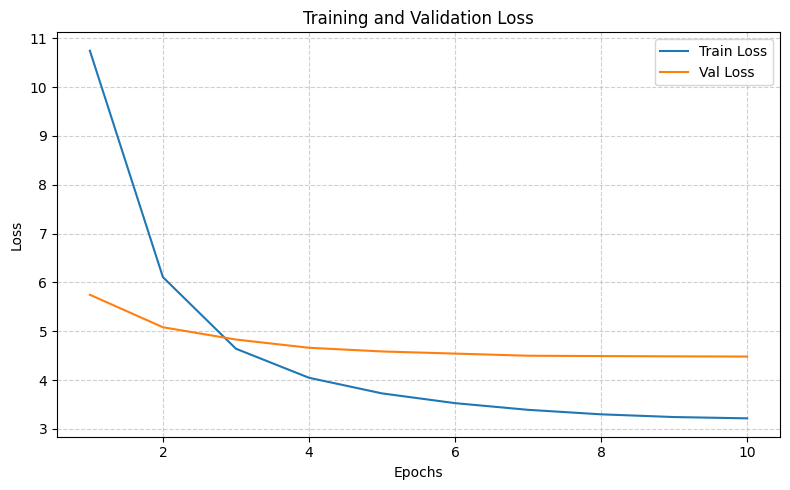

In [ ]:
# Plot Train and Validation loss

import numpy as np
import matplotlib.pyplot as plt

epochs = len(train_losses) # num_epochs
epoch_range = np.arange(1, epochs + 1)

plt.figure(figsize=(8, 5))
plt.plot(epoch_range, train_losses, label="Train Loss")
plt.plot(epoch_range, val_losses, label="Val Loss")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


# Step 11: Fine-Tuning the Model

Once the model ("large model") is trained (pre-trained), we move to the fine-tuning step. Fine-tuning means retraining only a small part of the model (typically the last layers) on a task or domain-specific dataset such as question-answer pairs.

First, we save our pre-trained model so we can run the following code independently of the pre-training (above code).

There are two ways to save the pre-trained model in the current directory:

1. Save only the model weights
    * This produces a smaller file and is sufficient for inference or fine-tuning.

2. Save the full training checkpoint (model + optimizer + epoch + losses)
    * This is only necessary if you want to resume training exactly from where it stopped, including optimizer state and learning-rate scheduling.

The code below have both options. Uncomment the one you need.

In [ ]:
# Save only the model
model_save_path = os.path.join(os.getcwd(), "DeepsSeek_v3_model.pt")
torch.save(model.state_dict(), model_save_path)
print(f"Model state dict saved at: {model_save_path}")

# Save full checkpoint
#checkpoint_save_path = os.path.join(os.getcwd(), "DeepsSeek_v3_checkpoint.pt")
#checkpoint = {
 #   'model_state_dict': model.state_dict(),
  #  'optimizer_state_dict': optimizer.state_dict(),
   # 'epoch': num_epochs,
    #'train_losses': train_losses,
    #'val_losses': val_losses
#}
#torch.save(checkpoint, checkpoint_save_path)
#print(f"Full checkpoint saved at: {checkpoint_save_path}")


Model state dict saved at: /content/drive/MyDrive/LLM/DeepsSeek_v3_model.pt


#### **Load the Model for Fine-Tuning**

Let's load the pretrained model `DeepsSeek_v3_model.pt` we saved in the previous step. I am naming it **ChatSPE** (**S**ociety of **P**etroleum **E**ngineers) but you are free to name it anything you want.

*Alternatively*, you may want to load any other model like GPT-2, but you will need to adjust the configuration accordingly.

In [ ]:
# Define model configurations
class Config:
    hidden_size = 128                # Embedding dimension (D)
    latent_dim = hidden_size // 2    # Latent dimension, half of D (a random choice)
    num_heads = 16                   # Number of attention heads (should divide hidden_size)
    pos_dim = 24                     # Positional encoding dimension
    pad_token_id = 50256             # Padding token ID (matches <|endoftext|> in GPT-2 vocab)
    num_shared_experts = 4
    num_routed_experts = 8
    top_k = 8                        # Kr, number of experts selected per token
    bias_update_speed = 0.01
    balance_alpha = 0.01
    lambda_mtp = 0.5                 # λ, weighting
    num_depths = 3                   # D, number of prediction depths
    vocab_size= vocab_size           # Vocab size of tiktoken’s GPT-2 vocab (50257), defined earlier
    layer_norm_eps = 1e-5            # Small epsilon value for numerical stability in layer normalization
    num_blocks = 12                  # Number of transformer blocks to stack in the model
    batch_size = 64                  # Number of sequences per batch
    context_length = 60              # Number of tokens per sequence


# Initialize configuration (config)
config = Config()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_save_path = os.path.join(os.getcwd(), "DeepsSeek_v3_model.pt")

# Load model only
ChatSPE = DeepSeek_V3_Model(config)
ChatSPE.load_state_dict(torch.load(model_save_path, map_location=device))
ChatSPE.to(device)  # ensure model is on the right device
ChatSPE.train()     # ready for fine-tuning
print("Model loaded.")

# Load full checkpoint
#checkpoint_save_path = os.path.join(os.getcwd(), "DeepsSeek_v3_checkpoint.pt")
#model_full = DeepSeek_V3_Model(config)
#optimizer_full = torch.optim.AdamW(model_full.parameters(), lr=5e-4, weight_decay=0.1)
# Load checkpoint to the correct device
#checkpoint_loaded = torch.load(checkpoint_save_path, map_location=device)
# Load model and optimizer states
#model_full.load_state_dict(checkpoint_loaded['model_state_dict'])
#optimizer_full.load_state_dict(checkpoint_loaded['optimizer_state_dict'])
# Move model to device after loading
#model_full.to(device)
#start_epoch = checkpoint_loaded['epoch']
#print(f"Full checkpoint loaded. Resuming from epoch {start_epoch}")



Model loaded.


After loading the pre-trained model, we have to do two things before fine-tuning:

1. Prepare the task-specific dataset.
2. Decide which layers to fine-tune (full or partial).



#### **Prepare the task-specific dataset:**
Below are ten short prompts with their corresponding responses (generated by ChatGPT). But you can use any dataset you want. DeepSeek V3 uses 1.5 millions of prompt-response pairs spanning multiple domains for fine-tuning.

In [ ]:
txts = [
    ("Prompt: What is porosity?\nResponse:", " Porosity is the fraction of a rock’s bulk volume that consists of pore space.<|endoftext|>"),
    ("Prompt: What does permeability measure?\nResponse:", " Permeability measures a rock’s ability to transmit fluids through connected pores.<|endoftext|>"),
    ("Prompt: What is Darcy’s law used for?\nResponse:", " Darcy’s law describes fluid flow through porous media.<|endoftext|>"),
    ("Prompt: What is water saturation?\nResponse:", " Water saturation is the fraction of pore volume occupied by water.<|endoftext|>"),
    ("Prompt: What is formation volume factor?\nResponse:", " Formation volume factor relates fluid volume at reservoir conditions to surface conditions.<|endoftext|>"),
    ("Prompt: What is primary recovery?\nResponse:", " Primary recovery is oil production driven by the reservoir’s natural energy.<|endoftext|>"),
    ("Prompt: What is capillary pressure?\nResponse:", " Capillary pressure is the pressure difference between two immiscible fluids in porous media.<|endoftext|>"),
    ("Prompt: What is a reservoir?\nResponse:", " A reservoir is a subsurface rock formation that stores hydrocarbons.<|endoftext|>"),
    ("Prompt: What does API gravity indicate?\nResponse:", " API gravity indicates the density of crude oil relative to water.<|endoftext|>"),
    ("Prompt: What is enhanced oil recovery?\nResponse:", " Enhanced oil recovery uses external energy or chemicals to increase oil production beyond primary and secondary recovery.<|endoftext|>")
]


The below `PromptResponseDataset` code defines a dataset that returns tokenized prompt-response pairs.

In [ ]:
from torch.utils.data import Dataset

class PromptResponseDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        prompt, response = self.data[idx]

        # tokenize separately and concatenate
        prompt_ids = tokenizer.encode(prompt, allowed_special={"<|endoftext|>"})
        response_ids = tokenizer.encode(response, allowed_special={"<|endoftext|>"})

        # combine prompt and response
        full_ids = prompt_ids + response_ids
        #full_ids = [min(i, 50256) for i in full_ids]  # clamp to vocab range


        # return tensor of token IDs and prompt length (for masking during training)
        return {
            "input_ids": torch.tensor(full_ids, dtype=torch.long),
            "prompt_len": len(prompt_ids)
        }


The below `collate_fn` code returns input and target tensors ready for training. It pads a batch of tokenized prompt-response pairs, shifts them for language modeling, masks the prompt and padding tokens...

In [ ]:
def collate_fn(batch, pad_token_id=50256, ignore_index=-100, device="cpu"):

    # find max length in batch
    max_len = max(len(item["input_ids"]) for item in batch)

    input_batch = []
    target_batch = []

    for item in batch:
        ids = item["input_ids"]
        prompt_len = item["prompt_len"]

        # pad
        padded = torch.full((max_len,), pad_token_id, dtype=torch.long)
        padded[:len(ids)] = ids

        # shift for LM (Language Model) objective
        inputs = padded[:-1]
        targets = padded[1:].clone()

        # mask padding (keep first pad token, mask the rest)
        mask_positions = (padded[1:] == pad_token_id).nonzero(as_tuple=True)[0]
        if len(mask_positions) > 0:
            targets[mask_positions[1:]] = ignore_index

        # mask prompt tokens, only response tokens trained
        targets[:prompt_len-1] = ignore_index

        # Replace -100 with pad_token_id, so ignore_index=config.pad_token_id works without any error
        targets[targets == ignore_index] = pad_token_id

        input_batch.append(inputs)
        target_batch.append(targets)

    input_batch = torch.stack(input_batch).to(device)
    target_batch = torch.stack(target_batch).to(device)

    return input_batch, target_batch


Split data into train and validation dataset

In [ ]:
from torch.utils.data import DataLoader

# 7 train, 3 validation
train_txts = txts[:7]
val_txts = txts[7:]

# Load GPT-2 tokenizer
tokenizer = tiktoken.get_encoding("gpt2")

train_dataset = PromptResponseDataset(train_txts,tokenizer)
val_dataset = PromptResponseDataset(val_txts,tokenizer)

train_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    collate_fn=lambda x: collate_fn(x, device=device)
)

val_loader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=False,
    collate_fn=lambda x: collate_fn(x, device=device)
)


#### **Decide which layers to fine-tune (full or partial):**

The code below is for full fine-tuning. If you prefer partial fine-tuning, I have included that as well, just uncomment the section after this.


In [ ]:
# Full fine-tuning
torch.manual_seed(123)

print(f"Full Fine-Tuning...")
for param in ChatSPE.parameters():
    param.requires_grad = True

trainable_params = [p for p in ChatSPE.parameters() if p.requires_grad]
total_trainable = sum(p.numel() for p in trainable_params)
print(f"Total trainable parameters: {total_trainable:,}")

optimizer = torch.optim.AdamW(trainable_params, lr=5e-4, weight_decay=0.1)

train_losses, val_losses, _, _ = train_model(
    ChatSPE,
    train_loader,
    val_loader,
    device=device,
    optimizer=optimizer,
    num_epochs=10,
    print_every=2,
    prompt="Prompt: What is porosity?"
)


Full Fine-Tuning...
Total trainable parameters: 29,756,561

------------ Epoch 2 completed ------------
[Epoch  2/10    Step  4/20] Total Loss  5.2656   |   Main Loss   4.8705  |  MTP Loss 0.3950   |  Learning Rate   0.000039
Train Loss: 5.3746,   Val Loss: 5.9746
Prompt: 'Prompt: What is porosity?'
Generated Text: 'Prompt: What is porosity?

For a function of time, the'

------------ Epoch 4 completed ------------
[Epoch  4/10    Step  8/20] Total Loss  5.1809   |   Main Loss   4.6758  |  MTP Loss 0.5051   |  Learning Rate   0.000049
Train Loss: 4.5629,   Val Loss: 5.9415
Prompt: 'Prompt: What is porosity?'
Generated Text: 'Prompt: What is porosity?

Water flow rate as the reservoir pressure'

------------ Epoch 6 completed ------------
[Epoch  6/10    Step  12/20] Total Loss  3.3607   |   Main Loss   3.0558  |  MTP Loss 0.3049   |  Learning Rate   0.000058
Train Loss: 3.8352,   Val Loss: 5.9844
Prompt: 'Prompt: What is porosity?'
Generated Text: 'Prompt: What is porosity?
 SPEarlo

In [ ]:
# Partial fine-tuning (uncomment to use): Remove """ and """ at the start and at the end to uncomment.
"""
torch.manual_seed(123)

# Fine-tune the last transformer block + output layer

# Freeze all parameters first
for param in ChatSPE.parameters():
    param.requires_grad = False

# Find last block
block_indices = set()
for name, _ in ChatSPE.named_parameters():
    if ".blocks." in name:
        # extract index between ".blocks." and next "."
        idx_str = name.split(".blocks.")[1].split(".")[0]
        block_indices.add(int(idx_str))

if not block_indices:
    raise ValueError("No transformer blocks found in model!")

# Last transformer block
last_block_idx = max(block_indices)

# Unfreeze last block
for name, param in ChatSPE.named_parameters():
    if f".blocks.{last_block_idx}." in name:
        param.requires_grad = True

# Unfreeze output layers
for name, param in ChatSPE.named_parameters():
    if name.startswith("model.output") or name.startswith("model.mtp.output_head"):
        param.requires_grad = True


trainable_params = [p for p in ChatSPE.parameters() if p.requires_grad]
total_trainable = sum(p.numel() for p in trainable_params)

optimizer = torch.optim.AdamW(trainable_params, lr=5e-4, weight_decay=0.1)

print(f"Partial Fine-Tuning...")
print(f"Training Last transformer block ({last_block_idx}) + output layer")
print(f"Total trainable parameters: {total_trainable:,}")

# Partial Fine-tune
train_losses, val_losses, _, _ = train_model(
    ChatSPE,
    train_loader,
    val_loader,
    device=device,
    optimizer=optimizer,
    num_epochs=10,
    print_every=2,
    prompt="Prompt: What is porosity?"
)
"""

'\ntorch.manual_seed(123)\n\n# Fine-tune the last transformer block + output layer\n\n# Freeze all parameters first\nfor param in ChatSPE.parameters():\n    param.requires_grad = False\n\n# Find last block\nblock_indices = set()\nfor name, _ in ChatSPE.named_parameters():\n    if ".blocks." in name:\n        # extract index between ".blocks." and next "."\n        idx_str = name.split(".blocks.")[1].split(".")[0]\n        block_indices.add(int(idx_str))\n\nif not block_indices:\n    raise ValueError("No transformer blocks found in model!")\n\n# Last transformer block\nlast_block_idx = max(block_indices)\n\n# Unfreeze last block\nfor name, param in ChatSPE.named_parameters():\n    if f".blocks.{last_block_idx}." in name:\n        param.requires_grad = True\n\n# Unfreeze output layers\nfor name, param in ChatSPE.named_parameters():\n    if name.startswith("model.output") or name.startswith("model.mtp.output_head"):\n        param.requires_grad = True\n\n\ntrainable_params = [p for p in C

# Step 12: Chat with your Model (Q&A)

The below function `clean_response` extracts the model's response cleanly, removing the prompt and <|endoftext|> from the generated text.

In [ ]:
def clean_response(generated_text):
    if not generated_text:
        return "Sorry, I couldn't generate a response."

    text = str(generated_text)

    # Print the prompt part
    if "Response:" in text:
        prompt_part = text.split("Response:", 1)[0] + "Response:"
    else:
        prompt_part = ""

    print("=======================================")
    print(f"{prompt_part.strip()}")

    # Extract response
    if "Response:" in text:
        text = text.split("Response:", 1)[1]

    # Truncate at <|endoftext|>
    if "<|endoftext|>" in text:
        text = text.split("<|endoftext|>", 1)[0]

    # Remove non-printable characters
    text = ''.join(c for c in text if c.isprintable() or c.isspace())

    # If text is empty after cleaning, return a default message
    if not text.strip():
        return "I'm not sure how to answer that. Could you ask in a different way?"

    return text.strip()

## Chat with **ChatSPE**

Below is the new prompt for chatting with our model. Please check the format of `new_prompt`.

In [ ]:
torch.manual_seed(123)

new_prompt = "Prompt: What is water saturation?\nResponse:" # replace it with your prompt

generated_answer = generate_text(
    ChatSPE,          # fine-tuned model
    tokenizer,
    new_prompt,
    max_length=50,    # max tokens to generate
    temperature=0.7,  # adjust creativity
    top_k=10,         # top-k sampling
    device=device
)


clean_answer = clean_response(generated_answer)
print(clean_answer)


Prompt: What is water saturation?
Response:
Oil recovery factor is the fraction of a pressure pore volume of a fluids.
The fraction of oil production data by water influx is the following steps:


Our fine-tuned model's prediction is still not very accurate. After all, the pretrained model was trained on just two books, and the fine-tuning used only ten samples. Generally, the more data, the more accurate the model's predictions.

**Evaluating the finetuned Model**

If you want to automate the response evaluation of the finetuned LLM using another LLM, please check **Section 7.8 Evaluating the finetuned LLM** of Sebastian Raschka GitHub repo of Chapter 7: Finetuning To Follow Instructions. Link is [here](https://github.com/rasbt/LLMs-from-scratch/blob/c278745aff419ae6c1d6409ca4279aa57ea749e4/ch07/01_main-chapter-code/ch07.ipynb).


# Step 13: Deploying Model to Production

Once you are satisfied with your model's predictions, it's time to deploy it to production. There are multiple deployment options for commercial use. For commercial deployment, common options include AWS (SageMaker/EC2), Google Cloud (Vertex AI), and Azure ML. However, for educational or demo purposes, as in our case, popular free option is Hugging Face Spaces.

### Deployment using Hugging Face Spaces

1. Go to https://huggingface.co and log in or sign up.
2. Navigate to Spaces → + New Space.
3. Choose a space name (e.g., ChatSPE).
4. Select:
    * SDK: Gradio
    * Hardware: CPU Basic
    * Visibility: Public
5. Click Create Space.

Your space will be created with default files such as `.gitattributes` and `README.md`. You now need to upload the following four files (use Git, VS Code, or the web editor if direct upload is unavailable):

<pre>
ChatSPE
├─ app.py
└─ model.py
└─ requirements.txt
└─ chatspe.pt
</pre>

### File Overview
* `app.py`: Contains the Gradio interface code required by Hugging Face. You can modify the title, description, and examples to match your project.
* `model.py`: Includes the full model implementation discussed earlier (excluding training and data preparation).
* `chatspe.pt`: Your fine-tuned model (see below code).
* `requirements.txt`: Lists all Python dependencies.

Once the build process completes successfully, your model will be live. You can interact with it in a ChatGPT-like interface and share the public link with others. The following space is the exact model trained and deployed in this guide:
https://huggingface.co/spaces/saifkhanengr/ChatSPE

The below code freeze (disable training behavior) and save our fine-tuned model in the folder named ChatSPE.

In [ ]:
# Save fine-tuned model

ChatSPE.eval()
for p in ChatSPE.parameters():
    p.requires_grad = False

# Save model weights only in ChatSPE folder
import os
os.makedirs("./ChatSPE", exist_ok=True)
torch.save(ChatSPE.state_dict(), "./ChatSPE/chatspe.pt")
print(f"chatspe.pt saved in ChatSPE")


chatspe.pt saved in ChatSPE


There you have it. You now know how to train your own LLM from scratch and fine-tune any model. This is the end of our journey. I hope you have learned a thing or two. However, remember that there is *more to do than can ever be done.* Learning is a lifelong journey, so keep learning, questioning, and researching, because *the more we know, the more we know that the less we know.*

If you notice any mistakes in my implementation or have suggestions for improvement, please feel free to open a GitHub issue or reach out to me on [LinkedIn](https://www.linkedin.com/in/saifkhanengr/) or [Facebook](https://www.facebook.com/saifkhanengr).

Goodbye and see you in the next project...